In [1]:
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu

/home/sungbeenpark/anaconda3/envs/algonauts/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# fMRI Data

The Algonauts dataset provides human brain responses to a set of 1,102 3-s long video clips of everyday events. The brain responses are measured with functional magnetic resonance imaging (fMRI). fMRI is a widely used brain imaging technique with high spatial resolution that measures blood flow changes associated with neural responses.

The training set consists of 1,000 video clips and the associated brain responses. The brain responses are provided here in two tracks corresponding to two independent tracks in the Algonauts challenge.

In the **full track**, brain responses provided are from selected voxels across the whole brain showing reliable responses to videos. The figure below shows the reliability values of different voxels in the brain.

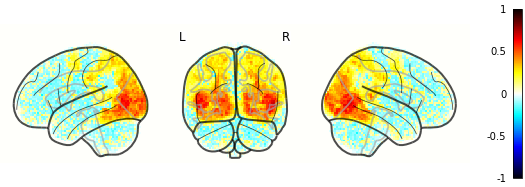

In the **mini track**, brain responses provided are from a set of specific regions of interest (ROIs) known to play a key role in visual perception. These ROIs start in early and mid-level visual cortex (V1, V2, V3, and V4) and extend into higher-level cortex that responds preferentially to all objects or particular categories (Body- EBA; Face - FFA, STS; Object - LOC; Scene - PPA). In the figure below we show the masks of the above mentioned ROIs for an example subject.

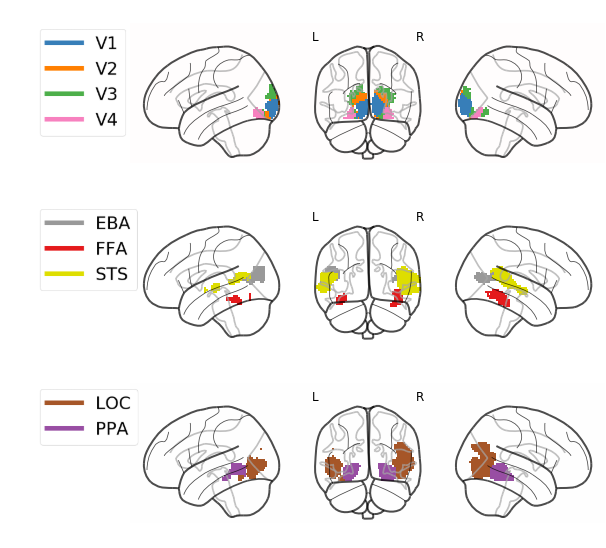

# Loading fMRI data

The trainig dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set. 

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [2]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

In [3]:
######## fMRI data loader wrapper code ###################################
dir_root = '/home/sungbeenpark/GoogleDrive/Algonauts_2021_challenge'
dir_fmri = os.path.join(dir_root,'participants_data_v2021')
dir_result = os.path.join(dir_root,'result')
dir_video = os.path.join(dir_root,'AlgonautsVideos268_All_30fpsmax')
os.makedirs(dir_result, exist_ok=True)

In [4]:
brain_mask = os.path.join(dir_root, 'example.nii')

In [5]:
list_subj = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
list_ROI = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
list_video = glob.glob(dir_video + '/*.mp4')
list_video.sort()

In [6]:
## title Loading fMRI data and inspecting dimensions
subj = random.sample(list_subj, k=1)[0]
ROI = random.sample(list_ROI, k=1)[0]
# ROI = 'WB'
print(subj, ROI)
#@title Visualize video
video_idx = random.randint(a=0, b=999)

track = 'full_track' if ROI=='WB' else 'mini_track'

sub09 LOC


In [7]:
dir_track = os.path.join(dir_fmri, track) 
dir_data = os.path.join(dir_track, subj)

In [8]:
def get_fmri(dir_data, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    dir_data : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """

    # Loading ROI data
    ROI_file = os.path.join(dir_data, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)
    print(ROI_data.keys())

    # averaging ROI data across repetitions. cf. (video, time, voxel)
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    voxel_mask = ROI_data['voxel_mask'] if ROI == 'WB' else None # (78, 93, 71)

    return ROI_data_train, voxel_mask

In [9]:
fmri_train_all, voxel_mask = get_fmri(dir_data, ROI)

dict_keys(['train'])


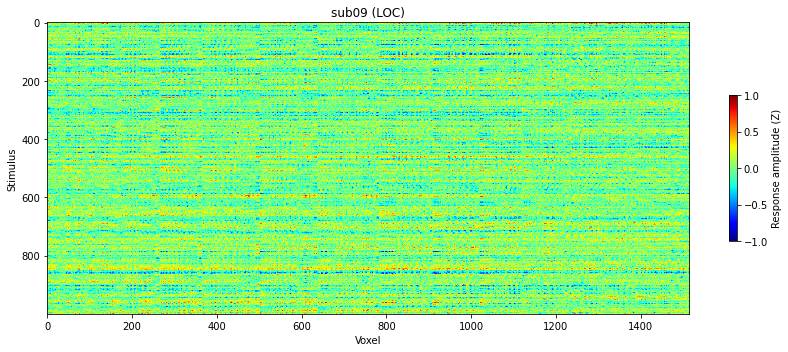

In [10]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus", title='%s (%s)'%(subj,ROI))
heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The above matrix shows each individual voxel's (columns) response to 1000 videos (rows). To find out more details about how the fMRI data were preprocessed please click [here](http://algonauts.csail.mit.edu/brainmappingandanalysis.html). 

Visualize a given video (with id from 0-999) and its corresponding brain activity

In [11]:
#visualize_brain_activity(video_dir,fmri_train_all,vid_id)
from IPython.display import HTML
from base64 import b64encode

print(list_video[video_idx])
mp4 = open(list_video[video_idx],'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)
########### Video display code #################################################

/home/sungbeenpark/GoogleDrive/Algonauts_2021_challenge/AlgonautsVideos268_All_30fpsmax/0407_flickr-2-4-2-4-4-5-5-1-6524244551_4.mp4


In [12]:
def saveasnii(brain_mask, fname, nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, fname)
    
def visualize_activity(video_idx, subj):
    train_whole_brain,voxel_mask = get_fmri(os.path.join(dir_fmri,'full_track',subj),"WB")
    visual_mask_3D = np.zeros((78,93,71))
    visual_mask_3D[voxel_mask==1]= train_whole_brain[video_idx,:]

    fname = os.path.join(dir_result, 'vid_activity.nii')
    saveasnii(brain_mask, fname, visual_mask_3D)
    plotting.plot_glass_brain(fname,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

dict_keys(['train', 'voxel_mask'])


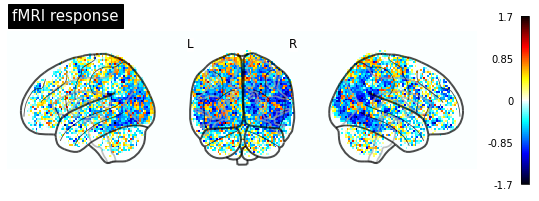

In [13]:
#@title Visualize corresponding brain response
visualize_activity(video_idx, subj)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos. 

# Vision Model definition (AlexNet)

Run the next cell to define the architecture of the model using pytorch.

In [14]:
#@title AlexNet
__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        #nn.Conv2d(batch, channel, height, width)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3, out4, out5, out6, out7, out8


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

# Feature Extraction
Run the next cell to extract Alexnet activations on the videos from the stimulus set. We will use these later to train a regression for predicting fMRI responses. 

In [15]:
def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

In [16]:
#@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """
    model = alexnet()
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model

def print_alexnet_predictions(output):
    with open(os.path.join(dir_root,'class_names_ImageNet.txt')) as labels:
        classes = [i.strip() for i in labels.readlines()]

    # sort the probability vector in descending order
    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0
    # obtain the first 5 classes (with the highest probability) the input belongs to
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    for i in range(5):
        print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
    

def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images,num_frames

def get_activations_and_save(model, video_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    video_list : list
        the list contains path to all videos.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    for video_file in tqdm(video_list):
        vid,num_frames = sample_video_from_mp4(video_file)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]
        activations = []
        for frame,img in enumerate(vid):
            input_img = V(resize_normalize(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img=input_img.cuda()
            x = model.forward(input_img)
            for i,feat in enumerate(x):
                if frame==0:
                    if i==7:
                        print("\nTop-5 Predictions for the video id: ", video_file_name)
                        print_alexnet_predictions(feat)
                    activations.append(feat.data.cpu().numpy().ravel())
                else:
                    activations[i] =  activations[i] + feat.data.cpu().numpy().ravel()
        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, video_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            avg_layer_activation = activations[layer]/float(num_frames)
            np.save(save_path,avg_layer_activation)

def do_PCA_and_save(activations_dir, save_dir):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    """

    layers = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']
    n_components = 100
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for layer in tqdm(layers):
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        x_train = x[:1000,:]
        x_test = x[1000:,:]

        start_time = time.time()
        x_test = StandardScaler().fit_transform(x_test)
        x_train = StandardScaler().fit_transform(x_train)
        ipca = PCA(n_components=n_components,random_state=seed)
        ipca.fit(x_train)

        x_train = ipca.transform(x_train)
        x_test = ipca.transform(x_test)
        train_save_path = os.path.join(save_dir,"train_"+layer)
        test_save_path = os.path.join(save_dir,"test_"+layer)
        np.save(train_save_path,x_train)
        np.save(test_save_path,x_test)

In [19]:
print('Total Number of Videos: ', len(list_video))
# load Alexnet
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = os.path.join(dir_root, 'alexnet.pth')
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, os.path.join(dir_root, 'alexnet.pth'))
model = load_alexnet(checkpoint_path)

# get and save activations
dir_save = os.path.join(dir_root, 'activations_alexnet')
dir_activation = os.path.join(dir_save)
os.makedirs(dir_activation, exist_ok=True)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, list_video, dir_activation)

Total Number of Videos:  1102
-------------Saving activations ----------------------------


  0%|          | 0/1102 [00:00<?, ?it/s]/tmp/ipykernel_968530/3409839398.py:69: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
/home/sungbeenpark/anaconda3/envs/algonauts/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return 


Top-5 Predictions for the video id:  0001_0-0-1-6-7-2-8-0-17500167280
red-breasted merganser, Mergus serrator: 47.7702%
American coot, marsh hen, mud hen, water hen, Fulica americana: 31.1746%
oystercatcher, oyster catcher: 4.4110%
drake: 3.4153%
dowitcher: 1.9704%


  0%|          | 1/1102 [00:27<8:29:17, 27.75s/it]


Top-5 Predictions for the video id:  0002_0-0-4-3146384004
Bouvier des Flandres, Bouviers des Flandres: 28.6529%
Scottish deerhound, deerhound: 9.3509%
standard schnauzer: 6.3253%
bulletproof vest: 5.2889%
Irish wolfhound: 3.4145%


  0%|          | 2/1102 [00:54<8:16:01, 27.06s/it]


Top-5 Predictions for the video id:  0003_0-0-8-1-2-4-0-0-3500812400
croquet ball: 65.2183%
golf ball: 8.7652%
soccer ball: 3.3299%
Bouvier des Flandres, Bouviers des Flandres: 2.7130%
parachute, chute: 1.4680%


  0%|          | 3/1102 [01:17<7:46:59, 25.50s/it]


Top-5 Predictions for the video id:  0004_0-1-2-9-1-9-9-5-2401291995
snowmobile: 44.3755%
bobsled, bobsleigh, bob: 23.6532%
dogsled, dog sled, dog sleigh: 19.1440%
ski: 5.0671%
swing: 1.1228%


  0%|          | 4/1102 [01:46<8:08:14, 26.68s/it]


Top-5 Predictions for the video id:  0005_0-1-7-8-3-6-4-8-4401783648
toyshop: 13.8630%
bobsled, bobsleigh, bob: 8.1237%
unicycle, monocycle: 5.9331%
barbershop: 5.1364%
volleyball: 3.8441%


  0%|          | 5/1102 [02:14<8:17:58, 27.24s/it]


Top-5 Predictions for the video id:  0006_0-1-9-9-8-6-5-9-4701998659
space bar: 50.4079%
crossword puzzle, crossword: 5.1754%
grocery store, grocery, food market, market: 4.6056%
library: 4.4197%
balance beam, beam: 3.9674%


  1%|          | 6/1102 [02:42<8:19:03, 27.32s/it]


Top-5 Predictions for the video id:  0007_0-2-3-14056753023
restaurant, eating house, eating place, eatery: 80.9636%
fire screen, fireguard: 1.4943%
cello, violoncello: 0.9887%
academic gown, academic robe, judge's robe: 0.8595%
palace: 0.7588%


  1%|          | 7/1102 [03:09<8:19:08, 27.35s/it]


Top-5 Predictions for the video id:  0008_0-2-9-6-5-7-2-3-16002965723_1
laptop, laptop computer: 8.9168%
desk: 8.2052%
perfume, essence: 6.2562%
carton: 3.1963%
face powder: 3.1604%


  1%|          | 8/1102 [03:35<8:07:58, 26.76s/it]


Top-5 Predictions for the video id:  0009_0-3-5-4-1-3-6-2-8603541362
plastic bag: 7.3271%
triceratops: 6.5714%
candle, taper, wax light: 5.6334%
half track: 4.9922%
dogsled, dog sled, dog sleigh: 4.2654%


  1%|          | 9/1102 [04:05<8:26:48, 27.82s/it]


Top-5 Predictions for the video id:  0010_0-3-6-10842732036
restaurant, eating house, eating place, eatery: 27.0389%
theater curtain, theatre curtain: 23.0627%
bassoon: 14.7832%
marimba, xylophone: 6.0169%
steel drum: 4.7769%


  1%|          | 10/1102 [04:35<8:39:50, 28.56s/it]


Top-5 Predictions for the video id:  0011_0-3-6-2-3-3-4-4-8103623344
ocarina, sweet potato: 16.9529%
restaurant, eating house, eating place, eatery: 13.4024%
dining table, board: 7.8783%
desk: 4.5298%
bakery, bakeshop, bakehouse: 4.1329%


  1%|          | 11/1102 [05:15<9:45:50, 32.22s/it]


Top-5 Predictions for the video id:  0012_0-5-3-7-6-2-8-4-24105376284
moving van: 17.5435%
bullet train, bullet: 12.8331%
photocopier: 9.4853%
passenger car, coach, carriage: 9.1265%
minibus: 8.6361%


  1%|          | 12/1102 [05:49<9:52:29, 32.61s/it]


Top-5 Predictions for the video id:  0013_0-5-3-8-6-8-2-6-4805386826
Welsh springer spaniel: 33.6788%
Brittany spaniel: 29.0815%
gyromitra: 13.2273%
basset, basset hound: 3.4555%
wire-haired fox terrier: 2.9183%


  1%|          | 13/1102 [06:22<9:52:01, 32.62s/it]


Top-5 Predictions for the video id:  0014_0-5-6-8272016056_edit
potter's wheel: 59.9825%
lab coat, laboratory coat: 5.2613%
stretcher: 4.5756%
barbershop: 3.3309%
oxygen mask: 3.0782%


  1%|▏         | 14/1102 [06:51<9:31:50, 31.54s/it]


Top-5 Predictions for the video id:  0015_0-6-1-9759583061
pool table, billiard table, snooker table: 34.9818%
wall clock: 8.8243%
croquet ball: 7.6348%
Petri dish: 5.5907%
tennis ball: 3.6123%


  1%|▏         | 15/1102 [07:19<9:11:50, 30.46s/it]


Top-5 Predictions for the video id:  0016_0-6-6-1-5-8-2-5-14806615825
potter's wheel: 61.6550%
iron, smoothing iron: 17.4274%
beaker: 4.4172%
nipple: 4.4083%
Petri dish: 2.6489%


  1%|▏         | 16/1102 [07:44<8:45:30, 29.03s/it]


Top-5 Predictions for the video id:  0017_0-7-3-5856076073
scoreboard: 10.3780%
tennis ball: 8.1005%
fire engine, fire truck: 5.0738%
torch: 4.6446%
comic book: 3.9521%


  2%|▏         | 17/1102 [08:15<8:54:16, 29.55s/it]


Top-5 Predictions for the video id:  0018_0-7-7-9-8-1-7-4-24407798174
ski: 90.2348%
bobsled, bobsleigh, bob: 3.2875%
dogsled, dog sled, dog sleigh: 1.9862%
snowmobile: 1.4547%
stretcher: 0.9753%


  2%|▏         | 18/1102 [08:43<8:47:33, 29.20s/it]


Top-5 Predictions for the video id:  0019_0-7-9-9-7-7-1-5-4307997715
fox squirrel, eastern fox squirrel, Sciurus niger: 95.3879%
grey fox, gray fox, Urocyon cinereoargenteus: 4.0743%
kit fox, Vulpes macrotis: 0.4036%
wood rabbit, cottontail, cottontail rabbit: 0.0966%
hare: 0.0138%


  2%|▏         | 19/1102 [09:15<9:01:20, 29.99s/it]


Top-5 Predictions for the video id:  0020_0-8-0-0-3-9-3-9-7108003939
pajama, pyjama, pj's, jammies: 8.6931%
balance beam, beam: 7.8854%
photocopier: 4.0558%
crib, cot: 3.0458%
feather boa, boa: 2.3350%


  2%|▏         | 20/1102 [09:41<8:36:19, 28.63s/it]


Top-5 Predictions for the video id:  0021_0-8-0-8-6-5-4-5-4708086545
agama: 5.6055%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 5.1272%
fox squirrel, eastern fox squirrel, Sciurus niger: 5.0061%
marmot: 4.2801%
mongoose: 4.1774%


  2%|▏         | 21/1102 [10:13<8:53:52, 29.63s/it]


Top-5 Predictions for the video id:  0022_0-8-7-7-9-6-5-5-6508779655
plate: 18.6945%
restaurant, eating house, eating place, eatery: 16.6340%
dining table, board: 8.1730%
Crock Pot: 7.0720%
consomme: 5.5107%


  2%|▏         | 22/1102 [10:39<8:35:54, 28.66s/it]


Top-5 Predictions for the video id:  0023_0-8-8-7346836088
ping-pong ball: 38.0215%
whistle: 6.3570%
neck brace: 4.6383%
bathing cap, swimming cap: 3.7322%
tricycle, trike, velocipede: 3.6224%


  2%|▏         | 23/1102 [11:08<8:36:52, 28.74s/it]


Top-5 Predictions for the video id:  0024_0-9-3-5943645093
African elephant, Loxodonta africana: 63.3984%
Indian elephant, Elephas maximus: 32.5290%
tusker: 2.2481%
swimming trunks, bathing trunks: 0.3458%
hog, pig, grunter, squealer, Sus scrofa: 0.3025%


  2%|▏         | 24/1102 [11:37<8:36:09, 28.73s/it]


Top-5 Predictions for the video id:  0025_0-9-5-1-8-2-6-6-4009518266
airliner: 64.1513%
warplane, military plane: 29.2798%
wing: 2.7416%
space shuttle: 1.3089%
projectile, missile: 1.0795%


  2%|▏         | 25/1102 [12:08<8:49:35, 29.50s/it]


Top-5 Predictions for the video id:  0026_0-9-9-8-0-5-8-5-4909980585
ambulance: 17.5994%
minibus: 14.6450%
stretcher: 13.1579%
limousine, limo: 12.7415%
recreational vehicle, RV, R.V.: 9.9466%


  2%|▏         | 26/1102 [12:35<8:32:37, 28.59s/it]


Top-5 Predictions for the video id:  0027_03chvdioZYI_85
trombone: 29.4233%
oboe, hautboy, hautbois: 11.6815%
flute, transverse flute: 10.5285%
cornet, horn, trumpet, trump: 8.9428%
stage: 5.8993%


  2%|▏         | 27/1102 [13:07<8:54:32, 29.84s/it]


Top-5 Predictions for the video id:  0028_0P6FNr_6XWo_35
oxygen mask: 5.5754%
banjo: 5.5645%
electric guitar: 4.6232%
oboe, hautboy, hautbois: 3.6620%
sax, saxophone: 3.5114%


  3%|▎         | 28/1102 [13:40<9:08:23, 30.64s/it]


Top-5 Predictions for the video id:  0029_1-0-7-2-7-1-8-6-2810727186
potter's wheel: 29.4157%
toyshop: 9.1456%
eggnog: 9.1074%
maraca: 3.9326%
mortar: 3.0421%


  3%|▎         | 29/1102 [14:09<8:59:20, 30.16s/it]


Top-5 Predictions for the video id:  0030_1-1-5-6-1-6-5-2-2811561652
hair slide: 19.1061%
maraca: 10.8845%
piggy bank, penny bank: 6.9285%
nipple: 6.1143%
whistle: 4.0519%


  3%|▎         | 30/1102 [14:38<8:55:18, 29.96s/it]


Top-5 Predictions for the video id:  0031_1-1-8-8-3-2-8-3-13711883283
ski: 90.0963%
snowmobile: 1.2531%
puck, hockey puck: 0.7724%
reel: 0.7472%
bobsled, bobsleigh, bob: 0.7403%


  3%|▎         | 31/1102 [15:12<9:16:39, 31.19s/it]


Top-5 Predictions for the video id:  0032_1-2-0-9-0-9-1-6-3812090916_61
corkscrew, bottle screw: 21.1095%
whistle: 9.6541%
pick, plectrum, plectron: 7.0145%
lighter, light, igniter, ignitor: 4.3486%
padlock: 3.8436%


  3%|▎         | 32/1102 [15:39<8:51:33, 29.81s/it]


Top-5 Predictions for the video id:  0033_1-2-5-1-2-7-6-2-2512512762
speedboat: 8.9459%
lakeside, lakeshore: 4.3314%
go-kart: 4.0407%
convertible: 4.0253%
seashore, coast, seacoast, sea-coast: 3.8903%


  3%|▎         | 33/1102 [16:09<8:50:25, 29.77s/it]


Top-5 Predictions for the video id:  0034_1-2-5-3344278125
bicycle-built-for-two, tandem bicycle, tandem: 91.9223%
mountain bike, all-terrain bike, off-roader: 3.3742%
tricycle, trike, velocipede: 2.6445%
moped: 1.1573%
jinrikisha, ricksha, rickshaw: 0.4868%


  3%|▎         | 34/1102 [16:35<8:31:24, 28.73s/it]


Top-5 Predictions for the video id:  0035_1-2-6-3176369126
dogsled, dog sled, dog sleigh: 39.5309%
snowmobile: 23.4227%
ski: 16.5318%
malamute, malemute, Alaskan malamute: 1.6466%
German shepherd, German shepherd dog, German police dog, alsatian: 1.6135%


  3%|▎         | 35/1102 [17:05<8:36:53, 29.07s/it]


Top-5 Predictions for the video id:  0036_1-2-6-9-6-8-2-1-22212696821
tabby, tabby cat: 23.1001%
Egyptian cat: 11.4815%
tiger cat: 7.6093%
shower cap: 3.6168%
nipple: 2.8574%


  3%|▎         | 36/1102 [17:35<8:41:19, 29.34s/it]


Top-5 Predictions for the video id:  0037_1-3-9-9-9-6-4-3-3213999643
plate: 40.1561%
hot pot, hotpot: 31.7905%
potpie: 5.6415%
waffle iron: 5.1486%
restaurant, eating house, eating place, eatery: 3.7131%


  3%|▎         | 37/1102 [18:06<8:53:02, 30.03s/it]


Top-5 Predictions for the video id:  0038_1-4-3-5-8-6-2-5-3114358625
ski: 52.8151%
snowplow, snowplough: 12.4731%
alp: 10.7636%
drilling platform, offshore rig: 4.0729%
swing: 1.5723%


  3%|▎         | 38/1102 [18:32<8:29:02, 28.71s/it]


Top-5 Predictions for the video id:  0039_1-4-4-4086629144
radio telescope, radio reflector: 15.0279%
solar dish, solar collector, solar furnace: 11.9790%
schooner: 6.9010%
water tower: 6.5380%
beaker: 5.0998%


  4%|▎         | 39/1102 [19:00<8:25:22, 28.53s/it]


Top-5 Predictions for the video id:  0040_1-4-8-8-7-8-7-5-3914887875_56
four-poster: 22.8500%
mosquito net: 15.0452%
binder, ring-binder: 8.8669%
envelope: 6.5306%
screen, CRT screen: 4.6860%


  4%|▎         | 40/1102 [19:28<8:21:49, 28.35s/it]


Top-5 Predictions for the video id:  0041_1-5-0-0-4-9-7-8-2915004978_2
lawn mower, mower: 63.0030%
golfcart, golf cart: 5.4034%
go-kart: 3.2609%
tractor: 3.2470%
Model T: 1.8579%


  4%|▎         | 41/1102 [19:54<8:07:00, 27.54s/it]


Top-5 Predictions for the video id:  0042_1-5-8-9-2-4-5-4-7815892454
balance beam, beam: 38.8677%
horizontal bar, high bar: 28.0033%
racket, racquet: 5.0942%
ballplayer, baseball player: 3.2562%
parallel bars, bars: 3.1073%


  4%|▍         | 42/1102 [20:25<8:24:07, 28.54s/it]


Top-5 Predictions for the video id:  0043_1-6-0-2796094160
scuba diver: 99.7956%
sea snake: 0.0560%
tiger shark, Galeocerdo cuvieri: 0.0443%
coral reef: 0.0258%
snorkel: 0.0208%


  4%|▍         | 43/1102 [21:03<9:17:09, 31.57s/it]


Top-5 Predictions for the video id:  0044_1-6-0-7-7-6-4-6-7816077646
planetarium: 31.1486%
lakeside, lakeshore: 6.6906%
parachute, chute: 3.8128%
alp: 3.0089%
airship, dirigible: 2.9674%


  4%|▍         | 44/1102 [21:38<9:36:10, 32.68s/it]


Top-5 Predictions for the video id:  0045_1-6-8-0-7-6-7-4-3816807674
neck brace: 21.6891%
oboe, hautboy, hautbois: 6.4779%
nipple: 5.7407%
whistle: 4.3860%
stethoscope: 4.2816%


  4%|▍         | 45/1102 [22:05<9:02:04, 30.77s/it]


Top-5 Predictions for the video id:  0046_1-6-8-5795643168
geyser: 50.4212%
valley, vale: 30.9242%
promontory, headland, head, foreland: 3.4594%
cliff, drop, drop-off: 3.1938%
yawl: 1.4043%


  4%|▍         | 46/1102 [22:39<9:18:25, 31.73s/it]


Top-5 Predictions for the video id:  0047_1-7-1-8-6-3-6-2-3417186362
warplane, military plane: 32.0957%
aircraft carrier, carrier, flattop, attack aircraft carrier: 16.3923%
liner, ocean liner: 3.5935%
projectile, missile: 3.0009%
spotlight, spot: 2.3498%


  4%|▍         | 47/1102 [23:09<9:10:28, 31.31s/it]


Top-5 Predictions for the video id:  0048_1-7-2-5-5-0-7-5-25617255075
abaya: 7.5188%
parallel bars, bars: 6.3829%
cliff dwelling: 4.3662%
stretcher: 3.6780%
bow: 2.8896%


  4%|▍         | 48/1102 [23:46<9:41:00, 33.07s/it]


Top-5 Predictions for the video id:  0049_1-7-4-5-3-8-3-6-3017453836
steel drum: 19.9990%
unicycle, monocycle: 10.1153%
stage: 7.3380%
Sussex spaniel: 3.6594%
rugby ball: 3.6161%


  4%|▍         | 49/1102 [24:14<9:10:41, 31.38s/it]


Top-5 Predictions for the video id:  0050_1-8-5-7127344185
tennis ball: 47.1773%
swimming trunks, bathing trunks: 4.9317%
trimaran: 3.5520%
racket, racquet: 3.4021%
catamaran: 3.1144%


  5%|▍         | 50/1102 [24:38<8:35:17, 29.39s/it]


Top-5 Predictions for the video id:  0051_1-8-7-1-1-9-6-6-5418711966
snowplow, snowplough: 93.1203%
snowmobile: 4.1844%
chain saw, chainsaw: 0.5640%
tractor: 0.4825%
lawn mower, mower: 0.3610%


  5%|▍         | 51/1102 [25:11<8:52:02, 30.37s/it]


Top-5 Predictions for the video id:  0052_1-9-3-0-9-4-6-4-4719309464
oxcart: 69.4622%
Arabian camel, dromedary, Camelus dromedarius: 20.2120%
Indian elephant, Elephas maximus: 4.7817%
horse cart, horse-cart: 1.1181%
tusker: 1.0272%


  5%|▍         | 52/1102 [25:44<9:06:19, 31.22s/it]


Top-5 Predictions for the video id:  0053_1-9-3-2-8-0-1-3-3919328013
comic book: 27.1557%
Afghan hound, Afghan: 7.1573%
Appenzeller: 4.0012%
bloodhound, sleuthhound: 3.3443%
tennis ball: 2.9875%


  5%|▍         | 53/1102 [26:11<8:44:01, 29.97s/it]


Top-5 Predictions for the video id:  0054_1-9-3-9-3-8-2-2-23719393822
seashore, coast, seacoast, sea-coast: 20.8060%
fountain: 15.0190%
water tower: 14.8872%
lakeside, lakeshore: 11.2720%
speedboat: 5.8528%


  5%|▍         | 54/1102 [26:44<8:55:12, 30.64s/it]


Top-5 Predictions for the video id:  0055_1-9-6-7-5-1-9-8-3119675198
potter's wheel: 54.3721%
eggnog: 4.8976%
restaurant, eating house, eating place, eatery: 4.1780%
toyshop: 4.0673%
shoe shop, shoe-shop, shoe store: 3.9064%


  5%|▍         | 55/1102 [27:20<9:23:04, 32.27s/it]


Top-5 Predictions for the video id:  0056_2-0-0-3614591200
promontory, headland, head, foreland: 52.2042%
seashore, coast, seacoast, sea-coast: 18.7202%
cliff, drop, drop-off: 7.2054%
geyser: 3.3434%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 2.7748%


  5%|▌         | 56/1102 [27:47<8:56:31, 30.78s/it]


Top-5 Predictions for the video id:  0057_2-0-9-8159444209
dam, dike, dyke: 77.6545%
fireboat: 5.1813%
lakeside, lakeshore: 3.9753%
geyser: 3.8277%
yawl: 1.9390%


  5%|▌         | 57/1102 [28:16<8:46:45, 30.24s/it]


Top-5 Predictions for the video id:  0058_2-4-3-5345273243
stage: 67.8237%
theater curtain, theatre curtain: 2.9894%
unicycle, monocycle: 1.3009%
panpipe, pandean pipe, syrinx: 1.2470%
cornet, horn, trumpet, trump: 0.9113%


  5%|▌         | 58/1102 [28:42<8:25:46, 29.07s/it]


Top-5 Predictions for the video id:  0059_2-5-7-6889839257
ski: 61.6288%
alp: 3.9074%
snowplow, snowplough: 2.1239%
shovel: 1.8553%
stretcher: 1.7832%


  5%|▌         | 59/1102 [29:11<8:26:09, 29.12s/it]


Top-5 Predictions for the video id:  0060_2-6-5-12330534265
dining table, board: 10.8986%
eggnog: 8.0625%
toyshop: 7.6420%
restaurant, eating house, eating place, eatery: 6.3804%
jigsaw puzzle: 3.8309%


  5%|▌         | 60/1102 [29:41<8:26:14, 29.15s/it]


Top-5 Predictions for the video id:  0061_2-9-5-4309863295
power drill: 7.7875%
barbershop: 7.4072%
oxygen mask: 4.3175%
jersey, T-shirt, tee shirt: 4.1690%
dumbbell: 3.7646%


  6%|▌         | 61/1102 [30:10<8:28:03, 29.28s/it]


Top-5 Predictions for the video id:  0062_2EMSeADyrrQ_35
rock beauty, Holocanthus tricolor: 22.9525%
tennis ball: 9.0511%
shopping basket: 6.8159%
space heater: 5.5724%
indigo bunting, indigo finch, indigo bird, Passerina cyanea: 2.8402%


  6%|▌         | 62/1102 [30:44<8:47:55, 30.46s/it]


Top-5 Predictions for the video id:  0063_2Ng8UYBFhbU_91
meat loaf, meatloaf: 13.7221%
dishrag, dishcloth: 13.4397%
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 7.9071%
pot, flowerpot: 4.4927%
Crock Pot: 3.2844%


  6%|▌         | 63/1102 [31:12<8:38:04, 29.92s/it]


Top-5 Predictions for the video id:  0064_2Tm26dLw29A_69
lawn mower, mower: 22.3867%
harvester, reaper: 19.0868%
tractor: 13.2936%
mobile home, manufactured home: 10.1179%
solar dish, solar collector, solar furnace: 3.2730%


  6%|▌         | 64/1102 [31:38<8:18:21, 28.81s/it]


Top-5 Predictions for the video id:  0065_2aG9AaxuGSU_148
television, television system: 40.9496%
home theater, home theatre: 25.5838%
monitor: 16.3739%
screen, CRT screen: 4.4053%
laptop, laptop computer: 3.1415%


  6%|▌         | 65/1102 [32:09<8:26:50, 29.33s/it]


Top-5 Predictions for the video id:  0066_2cCnDHUV0W8_35
miniskirt, mini: 28.0972%
abaya: 27.4609%
overskirt: 11.6465%
trench coat: 5.7297%
cowboy boot: 3.9419%


  6%|▌         | 66/1102 [32:37<8:22:23, 29.10s/it]


Top-5 Predictions for the video id:  0067_2h1Mj2ymyj8_121
unicycle, monocycle: 40.2320%
jinrikisha, ricksha, rickshaw: 10.7431%
tricycle, trike, velocipede: 8.8194%
bicycle-built-for-two, tandem bicycle, tandem: 7.1707%
oxcart: 4.2804%


  6%|▌         | 67/1102 [33:05<8:15:41, 28.74s/it]


Top-5 Predictions for the video id:  0068_3-0-4-4343808304
grocery store, grocery, food market, market: 56.8850%
toyshop: 16.8796%
confectionery, confectionary, candy store: 12.5122%
banana: 2.6172%
vending machine: 2.0252%


  6%|▌         | 68/1102 [33:39<8:42:38, 30.33s/it]


Top-5 Predictions for the video id:  0069_3-0-5-3-4-3-5-2-4730534352
oxcart: 30.2388%
potter's wheel: 7.7741%
stretcher: 5.9007%
assault rifle, assault gun: 4.2398%
sturgeon: 2.9996%


  6%|▋         | 69/1102 [34:10<8:45:17, 30.51s/it]


Top-5 Predictions for the video id:  0070_3-3-6-8-2-7-6-6-3533682766
vizsla, Hungarian pointer: 18.0545%
bloodhound, sleuthhound: 12.2339%
Rhodesian ridgeback: 7.7719%
bull mastiff: 3.9270%
malinois: 3.6059%


  6%|▋         | 70/1102 [34:38<8:31:46, 29.75s/it]


Top-5 Predictions for the video id:  0071_3-4-9-8-4-7-4-8-4434984748
airliner: 49.0981%
sports car, sport car: 8.9644%
racer, race car, racing car: 7.6708%
warplane, military plane: 3.7214%
mobile home, manufactured home: 3.2832%


  6%|▋         | 71/1102 [35:10<8:42:38, 30.42s/it]


Top-5 Predictions for the video id:  0072_3-5-0-4261181350
library: 15.8538%
potter's wheel: 12.3611%
guinea pig, Cavia cobaya: 12.1981%
toyshop: 9.8002%
barbershop: 6.3749%


  7%|▋         | 72/1102 [35:37<8:21:10, 29.19s/it]


Top-5 Predictions for the video id:  0073_3-5-8-9-9-5-9-8-4335899598
shovel: 54.1283%
ski: 20.4493%
ski mask: 12.0375%
chain saw, chainsaw: 2.4091%
bobsled, bobsleigh, bob: 2.3938%


  7%|▋         | 73/1102 [36:05<8:17:43, 29.02s/it]


Top-5 Predictions for the video id:  0074_3-6-5-3-3-4-4-5-23036533445
toyshop: 8.3275%
maillot, tank suit: 6.3983%
kimono: 5.3847%
sarong: 3.5958%
maillot: 2.9874%


  7%|▋         | 74/1102 [36:32<8:04:52, 28.30s/it]


Top-5 Predictions for the video id:  0075_3-7-0-7-1-5-3-0-4937071530
ping-pong ball: 14.6346%
nipple: 5.4645%
torch: 4.9767%
screen, CRT screen: 4.3876%
spaghetti squash: 3.0385%


  7%|▋         | 75/1102 [37:02<8:14:40, 28.90s/it]


Top-5 Predictions for the video id:  0076_3-7-3-13269577373
lifeboat: 34.4942%
speedboat: 29.8557%
trimaran: 11.5340%
fireboat: 9.6343%
yawl: 5.5512%


  7%|▋         | 76/1102 [37:32<8:17:06, 29.07s/it]


Top-5 Predictions for the video id:  0077_3-7-3-7-1-7-0-1-2537371701
plunger, plumber's helper: 8.9000%
dumbbell: 7.2785%
potter's wheel: 6.6854%
gasmask, respirator, gas helmet: 6.0019%
maraca: 5.8373%


  7%|▋         | 77/1102 [38:01<8:18:12, 29.16s/it]


Top-5 Predictions for the video id:  0078_3-7-5-4-7-7-8-9-8037547789
studio couch, day bed: 20.5114%
four-poster: 13.0220%
quilt, comforter, comfort, puff: 11.1620%
hair spray: 4.9703%
window shade: 3.3098%


  7%|▋         | 78/1102 [38:26<7:53:44, 27.76s/it]


Top-5 Predictions for the video id:  0079_3-7-5-6-6-4-1-7-3437566417
bicycle-built-for-two, tandem bicycle, tandem: 28.0089%
motor scooter, scooter: 18.0475%
moped: 10.6435%
crash helmet: 7.9722%
unicycle, monocycle: 7.8415%


  7%|▋         | 79/1102 [38:55<8:03:51, 28.38s/it]


Top-5 Predictions for the video id:  0080_3-9-0-6-4-2-6-6-3339064266
horizontal bar, high bar: 22.1194%
parallel bars, bars: 13.9183%
croquet ball: 8.7544%
tricycle, trike, velocipede: 7.6719%
swing: 3.3194%


  7%|▋         | 80/1102 [39:22<7:53:17, 27.79s/it]


Top-5 Predictions for the video id:  0081_4-0-6-7-6-1-4-5-4540676145
axolotl, mud puppy, Ambystoma mexicanum: 28.6196%
hamster: 24.2055%
piggy bank, penny bank: 6.4948%
nipple: 5.2246%
Angora, Angora rabbit: 2.2899%


  7%|▋         | 81/1102 [39:55<8:18:35, 29.30s/it]


Top-5 Predictions for the video id:  0082_4-2-5-6-5-3-6-5-16342565365
acoustic guitar: 86.9713%
electric guitar: 9.6783%
neck brace: 0.7795%
pick, plectrum, plectron: 0.6109%
banjo: 0.3768%


  7%|▋         | 82/1102 [40:25<8:24:04, 29.65s/it]


Top-5 Predictions for the video id:  0083_4-3-3-1-0-6-4-0-8743310640
water jug: 24.7135%
beaker: 17.9628%
hourglass: 12.4132%
Petri dish: 6.2063%
oxygen mask: 4.2557%


  8%|▊         | 83/1102 [40:56<8:27:51, 29.90s/it]


Top-5 Predictions for the video id:  0084_4-3-4-8736778434
joystick: 11.8090%
remote control, remote: 5.4652%
hand-held computer, hand-held microcomputer: 5.3993%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 4.7646%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 4.6938%


  8%|▊         | 84/1102 [41:22<8:10:19, 28.90s/it]


Top-5 Predictions for the video id:  0085_4-3-5-6-0-8-0-8-5543560808
shovel: 8.6783%
bobsled, bobsleigh, bob: 6.7516%
yurt: 3.6769%
Irish wolfhound: 3.6597%
hog, pig, grunter, squealer, Sus scrofa: 3.4683%


  8%|▊         | 85/1102 [41:50<8:03:21, 28.52s/it]


Top-5 Predictions for the video id:  0086_4-3-5-9059723435
nipple: 73.4600%
cradle: 5.3343%
diaper, nappy, napkin: 4.8818%
tub, vat: 3.1997%
ear, spike, capitulum: 2.5764%


  8%|▊         | 86/1102 [42:19<8:08:08, 28.83s/it]


Top-5 Predictions for the video id:  0087_4-3-7-4396869437
ski: 62.2108%
bobsled, bobsleigh, bob: 13.3234%
dogsled, dog sled, dog sleigh: 8.5937%
snowmobile: 7.4657%
shovel: 1.6626%


  8%|▊         | 87/1102 [42:46<7:57:32, 28.23s/it]


Top-5 Predictions for the video id:  0088_4-3-7-4889733437
tripod: 5.4893%
guillotine: 4.0259%
harp: 3.0726%
joystick: 2.4217%
candle, taper, wax light: 2.3347%


  8%|▊         | 88/1102 [43:15<8:02:45, 28.57s/it]


Top-5 Predictions for the video id:  0089_4-3-8-2-7-7-4-3-9043827743
valley, vale: 67.9287%
lakeside, lakeshore: 8.2237%
seashore, coast, seacoast, sea-coast: 1.7664%
head cabbage: 1.2811%
alp: 1.2722%


  8%|▊         | 89/1102 [43:48<8:23:37, 29.83s/it]


Top-5 Predictions for the video id:  0090_4-4-7-5-2-9-5-4-4744752954
paddle, boat paddle: 69.9678%
canoe: 21.6895%
barracouta, snoek: 2.1671%
yawl: 1.4635%
gar, garfish, garpike, billfish, Lepisosteus osseus: 1.1869%


  8%|▊         | 90/1102 [44:17<8:19:09, 29.59s/it]


Top-5 Predictions for the video id:  0091_4-5-0-1-4-3-5-1-15645014351
snowplow, snowplough: 23.1255%
parallel bars, bars: 16.5789%
puck, hockey puck: 14.6872%
bobsled, bobsleigh, bob: 6.9033%
amphibian, amphibious vehicle: 3.8125%


  8%|▊         | 91/1102 [44:46<8:13:09, 29.27s/it]


Top-5 Predictions for the video id:  0092_4-5-7-1-7-9-4-4-5945717944
warplane, military plane: 72.9125%
airliner: 8.8801%
wing: 6.7167%
space shuttle: 4.3804%
bow: 2.4674%


  8%|▊         | 92/1102 [45:15<8:11:30, 29.20s/it]


Top-5 Predictions for the video id:  0093_4-5-7-5265004457
plate: 12.3758%
candle, taper, wax light: 10.4908%
trifle: 4.9546%
hair slide: 4.4507%
ice cream, icecream: 4.3887%


  8%|▊         | 93/1102 [45:41<7:54:58, 28.24s/it]


Top-5 Predictions for the video id:  0094_4-5-9-2-3-0-7-9-15245923079
sturgeon: 35.4372%
gar, garfish, garpike, billfish, Lepisosteus osseus: 9.7308%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 9.2954%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 7.8166%
barracouta, snoek: 5.6521%


  9%|▊         | 94/1102 [46:20<8:47:52, 31.42s/it]


Top-5 Predictions for the video id:  0095_4-6-1-9-8-5-2-4-25546198524
ballplayer, baseball player: 73.5312%
baseball: 21.4258%
scoreboard: 1.0840%
racket, racquet: 1.0818%
pole: 0.6975%


  9%|▊         | 95/1102 [46:51<8:45:39, 31.32s/it]


Top-5 Predictions for the video id:  0096_4-7-1-1-2-8-3-0-25247112830
speedboat: 89.1013%
sandbar, sand bar: 3.2182%
canoe: 1.1518%
catamaran: 0.8859%
container ship, containership, container vessel: 0.5690%


  9%|▊         | 96/1102 [47:24<8:55:12, 31.92s/it]


Top-5 Predictions for the video id:  0097_4-7-9-4959184479
theater curtain, theatre curtain: 11.6739%
Afghan hound, Afghan: 10.5566%
torch: 4.1496%
unicycle, monocycle: 3.3070%
Welsh springer spaniel: 3.2974%


  9%|▉         | 97/1102 [47:53<8:39:40, 31.02s/it]


Top-5 Predictions for the video id:  0098_4-7-9-5224564479
lipstick, lip rouge: 12.4189%
punching bag, punch bag, punching ball, punchball: 9.2179%
bookcase: 8.0121%
turnstile: 7.1670%
lighter, light, igniter, ignitor: 4.1250%


  9%|▉         | 98/1102 [48:19<8:14:44, 29.57s/it]


Top-5 Predictions for the video id:  0099_4-7-9-5897473479
stretcher: 48.4141%
broom: 19.4779%
academic gown, academic robe, judge's robe: 2.4433%
maypole: 2.1980%
Loafer: 1.8319%


  9%|▉         | 99/1102 [48:43<7:46:07, 27.88s/it]


Top-5 Predictions for the video id:  0100_4-7-9-7-6-5-8-0-2647976580
balance beam, beam: 51.8194%
horizontal bar, high bar: 15.5185%
parallel bars, bars: 10.4707%
ping-pong ball: 9.0349%
maillot, tank suit: 4.7715%


  9%|▉         | 100/1102 [49:14<7:59:47, 28.73s/it]


Top-5 Predictions for the video id:  0101_4-8-4-5-2-8-6-4-12748452864
geyser: 70.7815%
volcano: 2.7358%
airship, dirigible: 2.1901%
fireboat: 1.4669%
beacon, lighthouse, beacon light, pharos: 0.9374%


  9%|▉         | 101/1102 [49:39<7:42:20, 27.71s/it]


Top-5 Predictions for the video id:  0102_4-8-9-2-5-7-3-1-3848925731
ice lolly, lolly, lollipop, popsicle: 30.7382%
maraca: 14.0274%
nipple: 11.4160%
whistle: 3.8716%
diaper, nappy, napkin: 3.6413%


  9%|▉         | 102/1102 [50:08<7:46:25, 27.99s/it]


Top-5 Predictions for the video id:  0103_4-9-0-4-8-4-8-7-3949048487
geyser: 99.8260%
volcano: 0.0421%
seashore, coast, seacoast, sea-coast: 0.0196%
beacon, lighthouse, beacon light, pharos: 0.0117%
hay: 0.0115%


  9%|▉         | 103/1102 [50:34<7:34:38, 27.31s/it]


Top-5 Predictions for the video id:  0104_4_mAU3U33fU_224
thresher, thrasher, threshing machine: 18.0534%
fire engine, fire truck: 16.1011%
tractor: 12.5856%
snowplow, snowplough: 7.4483%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 5.9470%


  9%|▉         | 104/1102 [51:04<7:50:26, 28.28s/it]


Top-5 Predictions for the video id:  0105_5-0-2-9044555502
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 17.2908%
limousine, limo: 13.7635%
recreational vehicle, RV, R.V.: 10.0144%
passenger car, coach, carriage: 8.0426%
moving van: 7.4653%


 10%|▉         | 105/1102 [51:30<7:38:44, 27.61s/it]


Top-5 Predictions for the video id:  0106_5-0-6-7-7-5-7-6-14950677576_1
mobile home, manufactured home: 36.7098%
go-kart: 6.0785%
garbage truck, dustcart: 4.3438%
lakeside, lakeshore: 3.3978%
recreational vehicle, RV, R.V.: 3.3472%


 10%|▉         | 106/1102 [51:59<7:42:42, 27.87s/it]


Top-5 Predictions for the video id:  0107_5-2-4-5-8-0-7-9-4752458079
mobile home, manufactured home: 7.2525%
pedestal, plinth, footstall: 5.4110%
guillotine: 4.7543%
bell cote, bell cot: 4.4707%
submarine, pigboat, sub, U-boat: 4.3002%


 10%|▉         | 107/1102 [52:27<7:46:30, 28.13s/it]


Top-5 Predictions for the video id:  0108_5-3-4-9966677534
speedboat: 25.0375%
lifeboat: 16.7633%
canoe: 16.1110%
fireboat: 9.4343%
snorkel: 7.9968%


 10%|▉         | 108/1102 [52:56<7:49:08, 28.32s/it]


Top-5 Predictions for the video id:  0109_5-3-7-1-9-2-1-2-3453719212
printer: 14.7319%
photocopier: 8.0596%
plate: 7.4728%
toaster: 7.2790%
cleaver, meat cleaver, chopper: 5.3848%


 10%|▉         | 109/1102 [53:22<7:36:12, 27.57s/it]


Top-5 Predictions for the video id:  0110_5-4-0-2405298540
trimaran: 74.0115%
catamaran: 13.2137%
speedboat: 5.7370%
yawl: 1.9599%
seashore, coast, seacoast, sea-coast: 0.8925%


 10%|▉         | 110/1102 [53:50<7:38:32, 27.73s/it]


Top-5 Predictions for the video id:  0111_5-4-2-6-1-5-0-7-5654261507
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 9.6421%
Norwegian elkhound, elkhound: 8.3692%
ox: 5.4036%
dogsled, dog sled, dog sleigh: 3.6963%
English setter: 3.2653%


 10%|█         | 111/1102 [54:23<8:01:52, 29.18s/it]


Top-5 Predictions for the video id:  0112_5-4-2-6-3-7-5-4-7854263754
skunk, polecat, wood pussy: 28.2006%
Old English sheepdog, bobtail: 7.5208%
valley, vale: 6.4318%
American alligator, Alligator mississipiensis: 5.1197%
komondor: 4.1272%


 10%|█         | 112/1102 [54:52<8:04:22, 29.36s/it]


Top-5 Predictions for the video id:  0113_5-4-3-5-0-8-5-4-13654350854_22
laptop, laptop computer: 23.7902%
library: 17.2394%
potter's wheel: 7.3462%
washer, automatic washer, washing machine: 4.9884%
stethoscope: 4.6251%


 10%|█         | 113/1102 [55:24<8:14:24, 29.99s/it]


Top-5 Predictions for the video id:  0114_5-4-5-2-2-4-8-5-8454522485
hot pot, hotpot: 49.6150%
consomme: 8.9027%
plate: 7.7635%
frying pan, frypan, skillet: 6.9126%
Dutch oven: 4.4397%


 10%|█         | 114/1102 [55:53<8:09:29, 29.73s/it]


Top-5 Predictions for the video id:  0115_5-4-5-4-1-8-6-5-8254541865_29
Sussex spaniel: 30.7698%
Irish setter, red setter: 17.2471%
briard: 14.8601%
Airedale, Airedale terrier: 6.7749%
Irish terrier: 2.5270%


 10%|█         | 115/1102 [56:26<8:23:31, 30.61s/it]


Top-5 Predictions for the video id:  0116_5-6-5-5-1-6-7-5-23256551675
face powder: 62.7344%
consomme: 28.6684%
espresso: 1.4696%
Petri dish: 1.2352%
beaker: 0.5604%


 11%|█         | 116/1102 [56:53<8:05:59, 29.57s/it]


Top-5 Predictions for the video id:  0117_5-6-6-3042970566
solar dish, solar collector, solar furnace: 6.9265%
standard poodle: 6.5923%
steel drum: 3.6873%
hoopskirt, crinoline: 3.1908%
Cardigan, Cardigan Welsh corgi: 2.9427%


 11%|█         | 117/1102 [57:22<8:04:05, 29.49s/it]


Top-5 Predictions for the video id:  0118_5-6-7-7-6-0-9-9-3756776099
lawn mower, mower: 8.6863%
apiary, bee house: 7.3202%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 5.4366%
milk can: 3.7799%
sundial: 3.0965%


 11%|█         | 118/1102 [57:48<7:47:00, 28.48s/it]


Top-5 Predictions for the video id:  0119_5-7-0-7-8-9-1-3-4257078913
theater curtain, theatre curtain: 32.5880%
vestment: 21.7017%
academic gown, academic robe, judge's robe: 14.8938%
Afghan hound, Afghan: 4.2904%
altar: 2.4372%


 11%|█         | 119/1102 [58:19<7:56:51, 29.11s/it]


Top-5 Predictions for the video id:  0120_5-7-5-3760841575
canoe: 29.2235%
speedboat: 15.8028%
sandbar, sand bar: 9.0452%
paddle, boat paddle: 8.1658%
lakeside, lakeshore: 8.0922%


 11%|█         | 120/1102 [58:46<7:49:06, 28.66s/it]


Top-5 Predictions for the video id:  0121_5-7-6-1-2-1-4-3-17357612143
jacamar: 56.5247%
bulbul: 14.2812%
squirrel monkey, Saimiri sciureus: 5.7091%
brambling, Fringilla montifringilla: 4.1009%
titi, titi monkey: 3.8139%


 11%|█         | 121/1102 [59:18<8:03:43, 29.59s/it]


Top-5 Predictions for the video id:  0122_5-7-6-9-5-4-8-2-5457695482
swimming trunks, bathing trunks: 24.1167%
diaper, nappy, napkin: 15.2886%
bathtub, bathing tub, bath, tub: 11.5408%
tub, vat: 9.0726%
parallel bars, bars: 7.1096%


 11%|█         | 122/1102 [59:45<7:50:27, 28.80s/it]


Top-5 Predictions for the video id:  0123_5-9-0-1-9-6-9-0-5259019690
pinwheel: 65.0023%
whistle: 10.4947%
rubber eraser, rubber, pencil eraser: 5.0317%
pick, plectrum, plectron: 2.5931%
jigsaw puzzle: 2.2869%


 11%|█         | 123/1102 [1:00:16<7:58:09, 29.31s/it]


Top-5 Predictions for the video id:  0124_5-9-1-5611850591
bobsled, bobsleigh, bob: 12.5261%
barbell: 9.6695%
balance beam, beam: 6.8301%
stretcher: 4.8800%
television, television system: 4.5951%


 11%|█▏        | 124/1102 [1:00:45<7:58:18, 29.34s/it]


Top-5 Predictions for the video id:  0125_5-9-4-9166960594
maypole: 39.7516%
ski: 8.2823%
oxcart: 5.6921%
jinrikisha, ricksha, rickshaw: 4.3819%
Afghan hound, Afghan: 3.1029%


 11%|█▏        | 125/1102 [1:01:16<8:04:25, 29.75s/it]


Top-5 Predictions for the video id:  0126_5-9-7-5-7-9-9-8-2859757998
valley, vale: 34.2038%
cliff, drop, drop-off: 10.7528%
fountain: 10.6332%
indri, indris, Indri indri, Indri brevicaudatus: 5.2405%
pedestal, plinth, footstall: 1.4920%


 11%|█▏        | 126/1102 [1:01:42<7:45:00, 28.59s/it]


Top-5 Predictions for the video id:  0127_5541389947
bobsled, bobsleigh, bob: 21.5334%
maillot: 13.7965%
throne: 3.7646%
kimono: 2.4832%
balance beam, beam: 2.3920%


 12%|█▏        | 127/1102 [1:02:10<7:42:22, 28.45s/it]


Top-5 Predictions for the video id:  0128_5948238182
balance beam, beam: 12.0717%
bathtub, bathing tub, bath, tub: 10.6132%
cradle: 7.1220%
tub, vat: 6.1414%
parallel bars, bars: 4.9640%


 12%|█▏        | 128/1102 [1:02:35<7:24:08, 27.36s/it]


Top-5 Predictions for the video id:  0129_5pZ8Z7icwxE_276
bookshop, bookstore, bookstall: 15.6897%
library: 10.7190%
refrigerator, icebox: 4.8220%
medicine chest, medicine cabinet: 4.5835%
carton: 4.3177%


 12%|█▏        | 129/1102 [1:03:04<7:35:44, 28.10s/it]


Top-5 Predictions for the video id:  0130_6-0-7-6496350607
soccer ball: 30.9775%
rugby ball: 15.1011%
croquet ball: 14.8863%
Saluki, gazelle hound: 5.9489%
football helmet: 5.6001%


 12%|█▏        | 130/1102 [1:03:33<7:38:38, 28.31s/it]


Top-5 Predictions for the video id:  0131_6-0-9-5-1-4-3-4-3260951434
ocarina, sweet potato: 11.7043%
hair slide: 5.0707%
acorn squash: 3.6792%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 3.5006%
quill, quill pen: 3.0948%


 12%|█▏        | 131/1102 [1:03:58<7:19:35, 27.16s/it]


Top-5 Predictions for the video id:  0132_6-1-0-8-4-3-3-3-2461084333
candle, taper, wax light: 9.7307%
Petri dish: 8.3305%
hair slide: 8.3272%
consomme: 5.3575%
trifle: 4.5951%


 12%|█▏        | 132/1102 [1:04:30<7:46:19, 28.84s/it]


Top-5 Predictions for the video id:  0133_6-2-2-4-7-1-0-3-6562247103
dumbbell: 27.8258%
parallel bars, bars: 7.8232%
horizontal bar, high bar: 6.0688%
ping-pong ball: 5.4702%
notebook, notebook computer: 4.6456%


 12%|█▏        | 133/1102 [1:05:02<7:57:28, 29.56s/it]


Top-5 Predictions for the video id:  0134_6-3-7-7169142637
electric locomotive: 82.6013%
passenger car, coach, carriage: 11.9767%
streetcar, tram, tramcar, trolley, trolley car: 2.6320%
steam locomotive: 0.4963%
garbage truck, dustcart: 0.4780%


 12%|█▏        | 134/1102 [1:05:39<8:34:07, 31.87s/it]


Top-5 Predictions for the video id:  0135_6-4-0-3-0-0-4-4-22064030044
basketball: 67.6843%
football helmet: 9.1043%
German shepherd, German shepherd dog, German police dog, alsatian: 3.2112%
soccer ball: 2.4080%
scoreboard: 2.3925%


 12%|█▏        | 135/1102 [1:06:08<8:21:11, 31.10s/it]


Top-5 Predictions for the video id:  0136_6-4-4-8-8-6-2-5-8164488625
caldron, cauldron: 21.0591%
frying pan, frypan, skillet: 13.9629%
wok: 11.9546%
Dutch oven: 6.4412%
barrow, garden cart, lawn cart, wheelbarrow: 6.0903%


 12%|█▏        | 136/1102 [1:06:39<8:20:15, 31.07s/it]


Top-5 Predictions for the video id:  0137_6-5-9-3859686659
steel drum: 16.8073%
toyshop: 9.2929%
confectionery, confectionary, candy store: 4.2449%
fountain: 3.6756%
desk: 3.3368%


 12%|█▏        | 137/1102 [1:07:14<8:38:40, 32.25s/it]


Top-5 Predictions for the video id:  0138_6-6-1-2641881661
canoe: 35.6278%
paddle, boat paddle: 17.7394%
drilling platform, offshore rig: 9.8654%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 4.3005%
snorkel: 3.8296%


 13%|█▎        | 138/1102 [1:07:42<8:15:34, 30.84s/it]


Top-5 Predictions for the video id:  0139_6-6-6-7-7-0-2-9-6866677029_1
stingray: 38.1166%
snorkel: 15.2230%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 5.0107%
swimming trunks, bathing trunks: 4.7593%
bathing cap, swimming cap: 2.7686%


 13%|█▎        | 139/1102 [1:08:18<8:42:52, 32.58s/it]


Top-5 Predictions for the video id:  0140_6-6-8-7-5-4-8-7-8066875487_24
cab, hack, taxi, taxicab: 21.2280%
streetcar, tram, tramcar, trolley, trolley car: 16.0497%
police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria: 15.7263%
ambulance: 11.8527%
racer, race car, racing car: 6.5920%


 13%|█▎        | 140/1102 [1:08:49<8:32:35, 31.97s/it]


Top-5 Predictions for the video id:  0141_6-7-0-1-4-8-8-0-9267014880
bee: 71.3262%
ant, emmet, pismire: 11.0288%
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle: 2.5401%
cauliflower: 1.9057%
hair slide: 1.7276%


 13%|█▎        | 141/1102 [1:09:20<8:26:01, 31.59s/it]


Top-5 Predictions for the video id:  0142_6-8-1-3-0-3-6-5-11768130365
oxcart: 58.9794%
horse cart, horse-cart: 23.9240%
dogsled, dog sled, dog sleigh: 4.4793%
Great Dane: 4.3971%
ox: 2.4040%


 13%|█▎        | 142/1102 [1:09:46<7:59:22, 29.96s/it]


Top-5 Predictions for the video id:  0143_6-8-5-2652653685
mobile home, manufactured home: 13.7775%
tow truck, tow car, wrecker: 9.3456%
limousine, limo: 8.3090%
amphibian, amphibious vehicle: 7.1375%
garbage truck, dustcart: 5.7356%


 13%|█▎        | 143/1102 [1:10:14<7:49:43, 29.39s/it]


Top-5 Predictions for the video id:  0144_6-gEVb8H_fk_649
envelope: 14.6968%
rubber eraser, rubber, pencil eraser: 6.4270%
sunglass: 4.0301%
swimming trunks, bathing trunks: 3.7609%
sunglasses, dark glasses, shades: 3.3913%


 13%|█▎        | 144/1102 [1:10:41<7:39:33, 28.78s/it]


Top-5 Predictions for the video id:  0145_7-0-7-8-4-7-5-8-14570784758
croquet ball: 25.5365%
Irish wolfhound: 11.7325%
chain saw, chainsaw: 5.5235%
Airedale, Airedale terrier: 5.0003%
Bouvier des Flandres, Bouviers des Flandres: 4.8461%


 13%|█▎        | 145/1102 [1:11:07<7:26:22, 27.99s/it]


Top-5 Predictions for the video id:  0146_7-1-5-1-5-3-3-7-7171515337
capuchin, ringtail, Cebus capucinus: 53.0324%
titi, titi monkey: 13.6267%
macaque: 9.8246%
gibbon, Hylobates lar: 7.4318%
patas, hussar monkey, Erythrocebus patas: 4.4447%


 13%|█▎        | 146/1102 [1:11:34<7:19:38, 27.59s/it]


Top-5 Predictions for the video id:  0147_7-1-6-7637947716
bearskin, busby, shako: 6.4832%
accordion, piano accordion, squeeze box: 5.5662%
abaya: 4.9674%
moving van: 3.4564%
fur coat: 3.3131%


 13%|█▎        | 147/1102 [1:12:03<7:27:23, 28.11s/it]


Top-5 Predictions for the video id:  0148_7-1-8-0-6-6-5-3-2471806653
umbrella: 7.0239%
horizontal bar, high bar: 6.2080%
feather boa, boa: 4.8928%
brassiere, bra, bandeau: 4.7959%
swing: 4.3371%


 13%|█▎        | 148/1102 [1:12:33<7:33:36, 28.53s/it]


Top-5 Predictions for the video id:  0149_7-1-8-7-4-8-0-6-2471874806
marimba, xylophone: 43.9633%
military uniform: 7.1443%
tobacco shop, tobacconist shop, tobacconist: 3.1370%
jinrikisha, ricksha, rickshaw: 2.9894%
mobile home, manufactured home: 2.5676%


 14%|█▎        | 149/1102 [1:13:00<7:26:48, 28.13s/it]


Top-5 Predictions for the video id:  0150_7-2-3-4-0-4-6-7-3872340467
Dutch oven: 65.3515%
frying pan, frypan, skillet: 10.7877%
caldron, cauldron: 7.7690%
stove: 4.6385%
Crock Pot: 2.5835%


 14%|█▎        | 150/1102 [1:13:29<7:30:45, 28.41s/it]


Top-5 Predictions for the video id:  0151_7-2-5-2-4-9-1-1-3572524911
diaper, nappy, napkin: 11.1985%
nipple: 10.9549%
candle, taper, wax light: 6.5984%
bathtub, bathing tub, bath, tub: 6.3219%
piggy bank, penny bank: 5.4115%


 14%|█▎        | 151/1102 [1:13:55<7:18:39, 27.68s/it]


Top-5 Predictions for the video id:  0152_7-3-2-8-5-5-7-0-2773285570_7
sea snake: 27.9141%
spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish: 19.7869%
electric ray, crampfish, numbfish, torpedo: 17.9080%
stingray: 8.4811%
eel: 8.0128%


 14%|█▍        | 152/1102 [1:14:23<7:18:15, 27.68s/it]


Top-5 Predictions for the video id:  0153_7-3-3-3-1-1-7-8-5973331178
abaya: 7.7628%
overskirt: 6.8522%
miniskirt, mini: 5.0705%
horizontal bar, high bar: 4.5536%
pole: 4.3038%


 14%|█▍        | 153/1102 [1:14:49<7:12:12, 27.33s/it]


Top-5 Predictions for the video id:  0154_7-3-3-8-1-7-0-5-5773381705
hot pot, hotpot: 32.6268%
American lobster, Northern lobster, Maine lobster, Homarus americanus: 16.0969%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 9.1628%
gyromitra: 8.4530%
rotisserie: 6.1539%


 14%|█▍        | 154/1102 [1:15:19<7:24:28, 28.13s/it]


Top-5 Predictions for the video id:  0155_7-3-3-9823355733
croquet ball: 15.7788%
Scottish deerhound, deerhound: 10.9661%
unicycle, monocycle: 7.4656%
Irish wolfhound: 4.3055%
golf ball: 4.0538%


 14%|█▍        | 155/1102 [1:15:46<7:16:32, 27.66s/it]


Top-5 Predictions for the video id:  0156_7-3-8-8-3-3-3-0-6873883330_5
coral reef: 18.2334%
stingray: 18.1938%
electric ray, crampfish, numbfish, torpedo: 14.5959%
hammerhead, hammerhead shark: 8.7881%
loggerhead, loggerhead turtle, Caretta caretta: 7.9858%


 14%|█▍        | 156/1102 [1:16:13<7:13:03, 27.47s/it]


Top-5 Predictions for the video id:  0157_7-4-3-9701238743
racket, racquet: 26.0896%
croquet ball: 9.2734%
golf ball: 8.2893%
ballplayer, baseball player: 4.7866%
bow: 3.6038%


 14%|█▍        | 157/1102 [1:16:43<7:25:39, 28.30s/it]


Top-5 Predictions for the video id:  0158_7-5-4-8-3-8-3-6-25975483836
ballplayer, baseball player: 79.2214%
baseball: 15.6845%
racket, racquet: 1.1230%
basenji: 0.7753%
volleyball: 0.2542%


 14%|█▍        | 158/1102 [1:17:11<7:21:13, 28.04s/it]


Top-5 Predictions for the video id:  0159_7-6-3-1-6-7-9-2-7876316792_13
geyser: 7.9943%
umbrella: 7.5241%
shovel: 5.1800%
swab, swob, mop: 4.1550%
crutch: 3.9715%


 14%|█▍        | 159/1102 [1:17:39<7:23:08, 28.20s/it]


Top-5 Predictions for the video id:  0160_7-7-0-2652639770
bicycle-built-for-two, tandem bicycle, tandem: 74.4271%
mountain bike, all-terrain bike, off-roader: 21.9791%
unicycle, monocycle: 1.0121%
tricycle, trike, velocipede: 0.5883%
Arabian camel, dromedary, Camelus dromedarius: 0.4407%


 15%|█▍        | 160/1102 [1:18:07<7:20:14, 28.04s/it]


Top-5 Predictions for the video id:  0161_7-7-2-8-9-8-8-7-3077289887
grocery store, grocery, food market, market: 61.2437%
toyshop: 17.0522%
tobacco shop, tobacconist shop, tobacconist: 4.4020%
confectionery, confectionary, candy store: 3.0066%
bakery, bakeshop, bakehouse: 2.7787%


 15%|█▍        | 161/1102 [1:18:42<7:52:17, 30.11s/it]


Top-5 Predictions for the video id:  0162_7-7-4-0-8-2-3-2-21577408232
croquet ball: 13.7266%
soccer ball: 11.3250%
golf ball: 7.0038%
rugby ball: 5.0552%
Rhodesian ridgeback: 2.8239%


 15%|█▍        | 162/1102 [1:19:11<7:47:47, 29.86s/it]


Top-5 Predictions for the video id:  0163_7-8-4-11617872784
coral reef: 81.8400%
sea snake: 8.6305%
scuba diver: 3.1831%
rock beauty, Holocanthus tricolor: 2.1212%
brain coral: 1.6850%


 15%|█▍        | 163/1102 [1:19:39<7:38:25, 29.29s/it]


Top-5 Predictions for the video id:  0164_7-8-4-4-0-9-0-9-3778440909
garbage truck, dustcart: 13.3000%
thresher, thrasher, threshing machine: 5.5763%
horse cart, horse-cart: 5.1740%
komondor: 3.9132%
Irish wolfhound: 3.3931%


 15%|█▍        | 164/1102 [1:20:09<7:40:54, 29.48s/it]


Top-5 Predictions for the video id:  0165_7-8-5-4189422785
croquet ball: 28.1111%
maypole: 18.9620%
lawn mower, mower: 6.4531%
soccer ball: 4.2226%
schipperke: 1.9463%


 15%|█▍        | 165/1102 [1:20:44<8:07:39, 31.23s/it]


Top-5 Predictions for the video id:  0166_7-9-1-9-1-3-1-5-5879191315
swing: 39.0461%
horizontal bar, high bar: 11.3572%
ballplayer, baseball player: 8.5843%
bow: 8.4823%
volleyball: 4.1917%


 15%|█▌        | 166/1102 [1:21:10<7:42:03, 29.62s/it]


Top-5 Predictions for the video id:  0167_7-9-2-5805821792
toyshop: 19.6360%
tobacco shop, tobacconist shop, tobacconist: 10.8276%
shoe shop, shoe-shop, shoe store: 8.8634%
grocery store, grocery, food market, market: 5.1414%
library: 4.6337%


 15%|█▌        | 167/1102 [1:21:40<7:41:46, 29.63s/it]


Top-5 Predictions for the video id:  0168_7-9-2-6804993792
croquet ball: 34.0434%
Irish wolfhound: 8.3124%
ballplayer, baseball player: 7.4960%
Saluki, gazelle hound: 6.4901%
baseball: 4.2924%


 15%|█▌        | 168/1102 [1:22:10<7:45:41, 29.92s/it]


Top-5 Predictions for the video id:  0169_7-9-4-13012552794
dugong, Dugong dugon: 19.7935%
hammerhead, hammerhead shark: 17.5636%
electric ray, crampfish, numbfish, torpedo: 5.9870%
tiger shark, Galeocerdo cuvieri: 5.8764%
sea snake: 5.5760%


 15%|█▌        | 169/1102 [1:22:41<7:50:54, 30.28s/it]


Top-5 Predictions for the video id:  0170_75FvTr78rVo_238
pinwheel: 11.0744%
piggy bank, penny bank: 10.9584%
whistle: 9.1813%
toaster: 8.5444%
rubber eraser, rubber, pencil eraser: 6.9778%


 15%|█▌        | 170/1102 [1:23:14<8:02:29, 31.06s/it]


Top-5 Predictions for the video id:  0171_8-1-0-2784666810
trimaran: 75.4775%
catamaran: 22.4911%
yawl: 0.5677%
schooner: 0.3018%
aircraft carrier, carrier, flattop, attack aircraft carrier: 0.2548%


 16%|█▌        | 171/1102 [1:23:47<8:08:29, 31.48s/it]


Top-5 Predictions for the video id:  0172_8-3-1-7-3-3-2-6-3583173326_54
stretcher: 12.9895%
golfcart, golf cart: 11.9081%
punching bag, punch bag, punching ball, punchball: 5.3352%
balance beam, beam: 5.1546%
gong, tam-tam: 3.9914%


 16%|█▌        | 172/1102 [1:24:17<8:00:55, 31.03s/it]


Top-5 Predictions for the video id:  0173_8-5-6-13941149856
Appenzeller: 11.4887%
standard schnauzer: 7.8935%
Saluki, gazelle hound: 7.7081%
Border collie: 7.4239%
Cardigan, Cardigan Welsh corgi: 4.5316%


 16%|█▌        | 173/1102 [1:24:50<8:11:24, 31.74s/it]


Top-5 Predictions for the video id:  0174_8-6-1-3575610861
tricycle, trike, velocipede: 10.4376%
neck brace: 5.5199%
maraca: 5.4630%
swab, swob, mop: 4.4128%
pay-phone, pay-station: 4.0925%


 16%|█▌        | 174/1102 [1:25:21<8:08:36, 31.59s/it]


Top-5 Predictions for the video id:  0175_8-6-7-3034848867
hair spray: 5.3186%
Indian cobra, Naja naja: 3.1135%
punching bag, punch bag, punching ball, punchball: 2.9460%
cowboy boot: 2.4437%
oxygen mask: 2.2507%


 16%|█▌        | 175/1102 [1:25:53<8:06:06, 31.46s/it]


Top-5 Predictions for the video id:  0176_8-7-1-7072478871
parallel bars, bars: 10.1801%
balance beam, beam: 9.6146%
swimming trunks, bathing trunks: 8.8723%
library: 7.9024%
sarong: 5.1760%


 16%|█▌        | 176/1102 [1:26:23<8:03:00, 31.30s/it]


Top-5 Predictions for the video id:  0177_8-7-5-4-7-4-9-9-6687547499
neck brace: 17.5947%
maraca: 15.4519%
balance beam, beam: 5.5408%
hair spray: 4.8188%
pajama, pyjama, pj's, jammies: 3.4233%


 16%|█▌        | 177/1102 [1:26:59<8:22:18, 32.58s/it]


Top-5 Predictions for the video id:  0178_8-7-8-2585165878
grocery store, grocery, food market, market: 48.3690%
shopping basket: 12.0749%
library: 8.3258%
toyshop: 5.5388%
tobacco shop, tobacconist shop, tobacconist: 5.3520%


 16%|█▌        | 178/1102 [1:27:29<8:09:55, 31.81s/it]


Top-5 Predictions for the video id:  0179_8-7-8-4802252878
tricycle, trike, velocipede: 89.8591%
lawn mower, mower: 4.3398%
swing: 3.4210%
croquet ball: 0.5225%
soccer ball: 0.5052%


 16%|█▌        | 179/1102 [1:28:00<8:05:58, 31.59s/it]


Top-5 Predictions for the video id:  0180_8-8-1-8014192881
comic book: 27.9256%
swimming trunks, bathing trunks: 13.0960%
snorkel: 9.0420%
stretcher: 8.4255%
whistle: 3.3300%


 16%|█▋        | 180/1102 [1:28:33<8:10:52, 31.94s/it]


Top-5 Predictions for the video id:  0181_8-9-0-3381035890
parallel bars, bars: 17.3591%
library: 14.2497%
bannister, banister, balustrade, balusters, handrail: 6.4511%
bullet train, bullet: 5.8319%
cradle: 3.1458%


 16%|█▋        | 181/1102 [1:29:07<8:17:59, 32.44s/it]


Top-5 Predictions for the video id:  0182_8-9-7-3822181897
golfcart, golf cart: 11.3012%
dumbbell: 10.2501%
neck brace: 8.9867%
maillot, tank suit: 8.0465%
brassiere, bra, bandeau: 4.0494%


 17%|█▋        | 182/1102 [1:29:36<8:06:07, 31.70s/it]


Top-5 Predictions for the video id:  0183_8709292427
potter's wheel: 18.3155%
oxygen mask: 7.9961%
library: 7.6791%
nipple: 5.7472%
candle, taper, wax light: 5.1838%


 17%|█▋        | 183/1102 [1:30:09<8:10:11, 32.00s/it]


Top-5 Predictions for the video id:  0184_8bbL5ZTo8J4_322
spaghetti squash: 14.1254%
space bar: 12.3222%
conch: 8.4238%
ear, spike, capitulum: 4.7858%
typewriter keyboard: 3.3168%


 17%|█▋        | 184/1102 [1:30:41<8:10:22, 32.05s/it]


Top-5 Predictions for the video id:  0185_9-0-0-5-1-3-8-3-14090051383
geyser: 98.3266%
volcano: 1.4331%
seashore, coast, seacoast, sea-coast: 0.0726%
alp: 0.0126%
lakeside, lakeshore: 0.0106%


 17%|█▋        | 185/1102 [1:31:16<8:22:45, 32.90s/it]


Top-5 Predictions for the video id:  0186_9-0-3-0-6-1-0-2-16890306102
canoe: 27.6964%
maypole: 22.7963%
paddle, boat paddle: 20.8410%
volleyball: 3.5966%
go-kart: 1.8346%


 17%|█▋        | 186/1102 [1:31:47<8:13:36, 32.33s/it]


Top-5 Predictions for the video id:  0187_9-1-4-8-0-4-3-2-4391480432
library: 18.2687%
tobacco shop, tobacconist shop, tobacconist: 16.4153%
toyshop: 15.9765%
grocery store, grocery, food market, market: 10.1134%
stretcher: 2.9121%


 17%|█▋        | 187/1102 [1:32:20<8:12:56, 32.32s/it]


Top-5 Predictions for the video id:  0188_9-1-6-3-6-9-9-7-4791636997
scuba diver: 60.7333%
snorkel: 14.4055%
dugong, Dugong dugon: 6.3444%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 2.8786%
tiger shark, Galeocerdo cuvieri: 2.5938%


 17%|█▋        | 188/1102 [1:32:51<8:08:03, 32.04s/it]


Top-5 Predictions for the video id:  0189_9-3-3-3-4-8-5-2-3193334852
geyser: 98.4056%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.6551%
volcano: 0.3628%
seashore, coast, seacoast, sea-coast: 0.1677%
fountain: 0.0542%


 17%|█▋        | 189/1102 [1:33:23<8:07:23, 32.03s/it]


Top-5 Predictions for the video id:  0190_9-3-6-5336600936
shovel: 46.1941%
ski: 17.4392%
snorkel: 5.0110%
catamaran: 1.9092%
scuba diver: 1.8758%


 17%|█▋        | 190/1102 [1:33:58<8:18:45, 32.81s/it]


Top-5 Predictions for the video id:  0191_9-3-7-9-4-7-7-2-15393794772
scuba diver: 39.7926%
hammerhead, hammerhead shark: 15.2209%
jellyfish: 11.6828%
dugong, Dugong dugon: 7.3886%
coral reef: 4.8680%


 17%|█▋        | 191/1102 [1:34:27<8:03:47, 31.86s/it]


Top-5 Predictions for the video id:  0192_9-4-9-8061428949
ballplayer, baseball player: 11.1576%
feather boa, boa: 8.4847%
axolotl, mud puppy, Ambystoma mexicanum: 6.1633%
standard poodle: 3.5554%
swimming trunks, bathing trunks: 2.8041%


 17%|█▋        | 192/1102 [1:35:02<8:18:15, 32.85s/it]


Top-5 Predictions for the video id:  0193_9-5-5-4087587955
balance beam, beam: 13.6554%
potter's wheel: 13.4486%
dumbbell: 4.5364%
paddle, boat paddle: 3.2610%
hair spray: 2.9711%


 18%|█▊        | 193/1102 [1:35:35<8:15:48, 32.73s/it]


Top-5 Predictions for the video id:  0194_9-6-0-4-3-8-6-5-17196043865
library: 17.4290%
barbell: 16.2498%
Kerry blue terrier: 11.6940%
dumbbell: 7.9839%
parallel bars, bars: 5.3071%


 18%|█▊        | 194/1102 [1:36:07<8:10:47, 32.43s/it]


Top-5 Predictions for the video id:  0195_9-8-1-5713854981
punching bag, punch bag, punching ball, punchball: 18.9782%
bobsled, bobsleigh, bob: 9.1228%
balloon: 7.8830%
toyshop: 3.3711%
maraca: 3.3004%


 18%|█▊        | 195/1102 [1:36:37<7:59:42, 31.73s/it]


Top-5 Predictions for the video id:  0196_9-8-8-3-3-0-9-9-3998833099
bobsled, bobsleigh, bob: 8.1327%
library: 7.6858%
academic gown, academic robe, judge's robe: 7.5251%
barbershop: 7.0291%
hand-held computer, hand-held microcomputer: 5.0897%


 18%|█▊        | 196/1102 [1:37:30<9:35:35, 38.12s/it]


Top-5 Predictions for the video id:  0197_C_T0k4u1WVA_6
pool table, billiard table, snooker table: 15.2312%
punching bag, punch bag, punching ball, punchball: 4.9594%
television, television system: 4.6154%
Mexican hairless: 3.9050%
power drill: 3.8577%


 18%|█▊        | 197/1102 [1:37:59<8:57:06, 35.61s/it]


Top-5 Predictions for the video id:  0198_HK42zQTEb1g_232
stage: 53.4137%
bassoon: 7.9123%
trombone: 6.0326%
drumstick: 4.7403%
cornet, horn, trumpet, trump: 4.1171%


 18%|█▊        | 198/1102 [1:38:30<8:34:07, 34.12s/it]


Top-5 Predictions for the video id:  0199_KrKLuEmzcBM_26
hamper: 11.8420%
quilt, comforter, comfort, puff: 9.9518%
Chihuahua: 7.1493%
trifle: 4.7015%
bassinet: 3.9820%


 18%|█▊        | 199/1102 [1:39:02<8:23:19, 33.44s/it]


Top-5 Predictions for the video id:  0200_L0axrvyv6co_40
dumbbell: 47.6040%
barbell: 5.0740%
Mexican hairless: 4.0536%
punching bag, punch bag, punching ball, punchball: 3.5489%
neck brace: 2.6590%


 18%|█▊        | 200/1102 [1:39:35<8:22:49, 33.45s/it]


Top-5 Predictions for the video id:  0201_LnIGqQ6uIls_28
cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM: 32.3275%
barbell: 19.2065%
ping-pong ball: 10.2754%
web site, website, internet site, site: 6.5227%
moving van: 2.6921%


 18%|█▊        | 201/1102 [1:40:09<8:20:49, 33.35s/it]


Top-5 Predictions for the video id:  0202_OeYnX9NwB1k_7
beagle: 72.4487%
basset, basset hound: 9.3517%
Blenheim spaniel: 2.6255%
Brittany spaniel: 2.2326%
boxer: 1.5587%


 18%|█▊        | 202/1102 [1:40:40<8:13:04, 32.87s/it]


Top-5 Predictions for the video id:  0203_VJkSUu4f83Q_50
snowplow, snowplough: 44.5669%
tractor: 39.2863%
harvester, reaper: 5.0218%
half track: 4.1853%
thresher, thrasher, threshing machine: 3.2427%


 18%|█▊        | 203/1102 [1:41:14<8:16:15, 33.12s/it]


Top-5 Predictions for the video id:  0204_a7hMxItSNjQ_99
parallel bars, bars: 24.8501%
barbell: 9.0602%
jinrikisha, ricksha, rickshaw: 8.5479%
bearskin, busby, shako: 7.3606%
volleyball: 6.5102%


 19%|█▊        | 204/1102 [1:41:44<8:02:30, 32.24s/it]


Top-5 Predictions for the video id:  0205_aahG-A2T4Ro_192
rubber eraser, rubber, pencil eraser: 50.7885%
pill bottle: 20.0971%
jigsaw puzzle: 5.0939%
pinwheel: 4.5904%
ping-pong ball: 3.5515%


 19%|█▊        | 205/1102 [1:42:16<8:01:29, 32.21s/it]


Top-5 Predictions for the video id:  0206_attsYxVO2pM_122
balance beam, beam: 23.8683%
barbell: 7.7094%
horizontal bar, high bar: 5.8213%
parallel bars, bars: 4.1493%
spotlight, spot: 2.7821%


 19%|█▊        | 206/1102 [1:42:48<7:58:44, 32.06s/it]


Top-5 Predictions for the video id:  0207_bing-www_dailymotion_com_video_x68vowz_2
axolotl, mud puppy, Ambystoma mexicanum: 68.5865%
brassiere, bra, bandeau: 2.9148%
ice cream, icecream: 1.4282%
earthstar: 1.1407%
tick: 0.9892%


 19%|█▉        | 207/1102 [1:43:21<8:01:55, 32.31s/it]


Top-5 Predictions for the video id:  0208_bing-www_facebook_com_sewwhatalicia_videos_1148889631878967__612
hand blower, blow dryer, blow drier, hair dryer, hair drier: 14.5368%
oxygen mask: 4.8986%
cradle: 4.1523%
balance beam, beam: 4.1482%
neck brace: 4.1056%


 19%|█▉        | 208/1102 [1:43:54<8:03:50, 32.47s/it]


Top-5 Predictions for the video id:  0209_bing-www_wikihow_com_Button-a-Suit_82
seat belt, seatbelt: 28.2244%
suit, suit of clothes: 3.2995%
parallel bars, bars: 3.1630%
lab coat, laboratory coat: 2.4446%
cloak: 2.2264%


 19%|█▉        | 209/1102 [1:44:25<7:57:07, 32.06s/it]


Top-5 Predictions for the video id:  0210_dwxnKkVw4Z0_143
crib, cot: 8.2561%
dumbbell: 8.2253%
parallel bars, bars: 8.1636%
prison, prison house: 6.2055%
plunger, plumber's helper: 5.2719%


 19%|█▉        | 210/1102 [1:44:56<7:51:49, 31.74s/it]


Top-5 Predictions for the video id:  0211_flickr-0-0-0-0-3-1-1-4-16000003114_1
croquet ball: 19.4590%
chimpanzee, chimp, Pan troglodytes: 10.7005%
curly-coated retriever: 5.3367%
Sealyham terrier, Sealyham: 2.7806%
Kerry blue terrier: 2.1417%


 19%|█▉        | 211/1102 [1:45:29<7:58:00, 32.19s/it]


Top-5 Predictions for the video id:  0212_flickr-0-0-0-1-9-7-6-6-5700019766_5
swing: 34.4389%
wire-haired fox terrier: 11.4062%
horizontal bar, high bar: 10.4080%
standard schnauzer: 3.8522%
malamute, malemute, Alaskan malamute: 3.4855%


 19%|█▉        | 212/1102 [1:45:59<7:46:49, 31.47s/it]


Top-5 Predictions for the video id:  0213_flickr-0-0-2-0-8-2-2-8-2400208228_3
American lobster, Northern lobster, Maine lobster, Homarus americanus: 51.1667%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 10.5983%
crayfish, crawfish, crawdad, crawdaddy: 8.4578%
hot pot, hotpot: 5.0568%
wok: 3.7579%


 19%|█▉        | 213/1102 [1:46:31<7:47:46, 31.57s/it]


Top-5 Predictions for the video id:  0214_flickr-0-0-2-6-5-7-8-4-10900265784_27
punching bag, punch bag, punching ball, punchball: 11.0567%
barbershop: 8.0146%
oxygen mask: 7.1606%
potter's wheel: 5.1483%
hair spray: 2.9971%


 19%|█▉        | 214/1102 [1:47:05<7:58:46, 32.35s/it]


Top-5 Predictions for the video id:  0215_flickr-0-0-3-7-1-7-7-4-10300371774_13
racer, race car, racing car: 44.1044%
go-kart: 14.0135%
sports car, sport car: 7.3521%
tow truck, tow car, wrecker: 6.1694%
bobsled, bobsleigh, bob: 4.6940%


 20%|█▉        | 215/1102 [1:47:42<8:20:00, 33.82s/it]


Top-5 Predictions for the video id:  0216_flickr-0-0-3-8-0-2-1-4-7000380214_32
alp: 58.1893%
seashore, coast, seacoast, sea-coast: 12.3062%
recreational vehicle, RV, R.V.: 3.2523%
lakeside, lakeshore: 2.9100%
valley, vale: 2.7011%


 20%|█▉        | 216/1102 [1:48:13<8:05:26, 32.87s/it]


Top-5 Predictions for the video id:  0217_flickr-0-0-3-8-6-7-6-9-18500386769_7
swimming trunks, bathing trunks: 78.5991%
bikini, two-piece: 8.7767%
bathing cap, swimming cap: 4.4595%
maillot, tank suit: 2.6086%
snorkel: 2.2853%


 20%|█▉        | 217/1102 [1:48:46<8:06:33, 32.99s/it]


Top-5 Predictions for the video id:  0218_flickr-0-0-3-9-1-2-6-1-2600391261_12
sandbar, sand bar: 43.9690%
canoe: 14.9830%
speedboat: 11.6869%
seashore, coast, seacoast, sea-coast: 9.6283%
paddle, boat paddle: 3.1844%


 20%|█▉        | 218/1102 [1:49:18<8:03:30, 32.82s/it]


Top-5 Predictions for the video id:  0219_flickr-0-0-5-0-5-7-9-5-4200505795_2
snowmobile: 37.7542%
Appenzeller: 5.8740%
ski: 5.5173%
flat-coated retriever: 4.2452%
Scotch terrier, Scottish terrier, Scottie: 4.1235%


 20%|█▉        | 219/1102 [1:49:51<8:02:13, 32.77s/it]


Top-5 Predictions for the video id:  0220_flickr-0-0-5-7-8-8-8-6-4800578886_8
plunger, plumber's helper: 11.2225%
bow: 8.1303%
swab, swob, mop: 6.0761%
tick: 5.2784%
vacuum, vacuum cleaner: 3.4701%


 20%|█▉        | 220/1102 [1:50:24<8:01:54, 32.78s/it]


Top-5 Predictions for the video id:  0221_flickr-0-0-6-6-3-9-4-5-4900663945_62
beer glass: 10.7990%
tray: 9.7382%
ping-pong ball: 7.5123%
beaker: 6.0907%
refrigerator, icebox: 4.7998%


 20%|██        | 221/1102 [1:50:59<8:10:24, 33.40s/it]


Top-5 Predictions for the video id:  0222_flickr-0-0-6-8-8-6-4-9-18100688649_2
unicycle, monocycle: 10.3991%
stretcher: 9.5196%
barrow, garden cart, lawn cart, wheelbarrow: 8.0290%
bicycle-built-for-two, tandem bicycle, tandem: 6.0702%
bobsled, bobsleigh, bob: 3.8047%


 20%|██        | 222/1102 [1:51:32<8:08:13, 33.29s/it]


Top-5 Predictions for the video id:  0223_flickr-0-0-8-4-5-7-3-6-3000845736_3
shower curtain: 29.4770%
jigsaw puzzle: 15.0155%
tray: 7.6917%
bib: 4.8694%
apron: 3.5861%


 20%|██        | 223/1102 [1:52:06<8:11:05, 33.52s/it]


Top-5 Predictions for the video id:  0224_flickr-0-0-8-6-3-9-7-8-4700863978_6
paddle, boat paddle: 15.6862%
snorkel: 9.2960%
canoe: 8.4783%
sandbar, sand bar: 7.7894%
bathing cap, swimming cap: 6.6339%


 20%|██        | 224/1102 [1:52:37<7:59:22, 32.76s/it]


Top-5 Predictions for the video id:  0225_flickr-0-0-9-0-4-3-5-7-14400904357_12
trilobite: 12.8774%
porcupine, hedgehog: 12.1949%
eggnog: 5.8264%
gong, tam-tam: 5.7757%
dowitcher: 4.4179%


 20%|██        | 225/1102 [1:53:09<7:57:41, 32.68s/it]


Top-5 Predictions for the video id:  0226_flickr-0-1-1-4-7-8-8-0-2801147880_27
maillot: 18.1651%
bikini, two-piece: 10.2941%
maillot, tank suit: 8.0827%
snorkel: 6.1309%
sunscreen, sunblock, sun blocker: 5.7228%


 21%|██        | 226/1102 [1:53:49<8:28:49, 34.85s/it]


Top-5 Predictions for the video id:  0227_flickr-0-1-6-1-8-9-0-0-5601618900_7
parallel bars, bars: 10.6816%
balance beam, beam: 7.6656%
whistle: 5.8952%
horizontal bar, high bar: 5.2378%
swing: 4.6822%


 21%|██        | 227/1102 [1:54:22<8:17:35, 34.12s/it]


Top-5 Predictions for the video id:  0228_flickr-0-1-6-4-5-9-7-4-12301645974_3
English springer, English springer spaniel: 13.4140%
shovel: 8.9188%
standard poodle: 7.1459%
Weimaraner: 4.2631%
ski: 3.7870%


 21%|██        | 228/1102 [1:54:52<8:01:46, 33.07s/it]


Top-5 Predictions for the video id:  0229_flickr-0-1-6-5-6-1-9-9-4701656199_6
hot pot, hotpot: 42.7500%
consomme: 17.8559%
wok: 4.6958%
frying pan, frypan, skillet: 4.5166%
caldron, cauldron: 4.3199%


 21%|██        | 229/1102 [1:55:24<7:55:52, 32.71s/it]


Top-5 Predictions for the video id:  0230_flickr-0-1-7-9-2-7-7-4-16001792774_3
Bouvier des Flandres, Bouviers des Flandres: 22.0125%
croquet ball: 8.4660%
barrow, garden cart, lawn cart, wheelbarrow: 5.8253%
apiary, bee house: 5.6469%
standard schnauzer: 5.5627%


 21%|██        | 230/1102 [1:55:58<7:58:54, 32.95s/it]


Top-5 Predictions for the video id:  0231_flickr-0-2-0-6-5-9-0-9-2402065909_10
bathing cap, swimming cap: 11.0119%
snowmobile: 7.9275%
shovel: 5.4731%
swimming trunks, bathing trunks: 5.4400%
snowplow, snowplough: 4.7435%


 21%|██        | 231/1102 [1:56:31<8:01:02, 33.14s/it]


Top-5 Predictions for the video id:  0232_flickr-0-2-3-12544471023_3_edit
paddle, boat paddle: 56.3192%
canoe: 41.4390%
snorkel: 0.8168%
stretcher: 0.4752%
bikini, two-piece: 0.2070%


 21%|██        | 232/1102 [1:57:09<8:22:31, 34.66s/it]


Top-5 Predictions for the video id:  0233_flickr-0-2-4-5-1-7-7-2-15002451772_20
cradle: 8.1365%
diaper, nappy, napkin: 5.3736%
bathtub, bathing tub, bath, tub: 4.2218%
tricycle, trike, velocipede: 4.1098%
tub, vat: 3.6272%


 21%|██        | 233/1102 [1:57:41<8:06:46, 33.61s/it]


Top-5 Predictions for the video id:  0234_flickr-0-2-5-2-4-5-4-3-2402524543_23
potter's wheel: 29.7360%
hand-held computer, hand-held microcomputer: 16.5053%
oxygen mask: 2.0238%
neck brace: 1.9630%
tobacco shop, tobacconist shop, tobacconist: 1.8224%


 21%|██        | 234/1102 [1:58:13<7:59:38, 33.16s/it]


Top-5 Predictions for the video id:  0235_flickr-0-2-5-6-0-1-4-0-2602560140_2
barracouta, snoek: 12.0208%
sturgeon: 11.3874%
tiger shark, Galeocerdo cuvieri: 7.3016%
shower cap: 5.0352%
hammerhead, hammerhead shark: 3.4929%


 21%|██▏       | 235/1102 [1:58:49<8:11:39, 34.02s/it]


Top-5 Predictions for the video id:  0236_flickr-0-2-8-1-1-8-8-3-5502811883_2
restaurant, eating house, eating place, eatery: 19.6303%
butcher shop, meat market: 13.8848%
bakery, bakeshop, bakehouse: 13.2306%
grocery store, grocery, food market, market: 11.8915%
confectionery, confectionary, candy store: 10.9774%


 21%|██▏       | 236/1102 [1:59:19<7:55:03, 32.91s/it]


Top-5 Predictions for the video id:  0237_flickr-0-2-8-2-2-8-3-3-16002822833_4
tench, Tinca tinca: 10.9284%
barrow, garden cart, lawn cart, wheelbarrow: 9.7330%
curly-coated retriever: 9.4779%
black-and-tan coonhound: 3.0235%
academic gown, academic robe, judge's robe: 2.4194%


 22%|██▏       | 237/1102 [1:59:54<8:01:56, 33.43s/it]


Top-5 Predictions for the video id:  0238_flickr-0-2-8-4-3-6-5-9-4702843659_25
maraca: 13.2224%
piggy bank, penny bank: 10.1790%
rubber eraser, rubber, pencil eraser: 5.6698%
sock: 3.2369%
snail: 2.7871%


 22%|██▏       | 238/1102 [2:00:33<8:26:29, 35.17s/it]


Top-5 Predictions for the video id:  0239_flickr-0-2-8-6-7-4-1-6-2502867416_28
vestment: 5.6997%
maypole: 5.3474%
crutch: 5.0927%
academic gown, academic robe, judge's robe: 3.9272%
neck brace: 3.5119%


 22%|██▏       | 239/1102 [2:01:08<8:24:21, 35.07s/it]


Top-5 Predictions for the video id:  0240_flickr-0-2-9-8-3-1-1-8-14302983118_5
Petri dish: 29.0887%
frying pan, frypan, skillet: 9.3587%
hair slide: 6.3638%
toilet seat: 2.9423%
eggnog: 2.9216%


 22%|██▏       | 240/1102 [2:01:42<8:19:13, 34.75s/it]


Top-5 Predictions for the video id:  0241_flickr-0-2-9-9-4-2-5-2-6002994252_14
maypole: 30.5639%
bearskin, busby, shako: 11.2330%
academic gown, academic robe, judge's robe: 9.0720%
bow: 3.0367%
Bouvier des Flandres, Bouviers des Flandres: 2.9636%


 22%|██▏       | 241/1102 [2:02:17<8:19:18, 34.79s/it]


Top-5 Predictions for the video id:  0242_flickr-0-3-0-7-9-7-3-7-15303079737_5
library: 47.8139%
bookshop, bookstore, bookstall: 42.2283%
bookcase: 5.4163%
tobacco shop, tobacconist shop, tobacconist: 0.7907%
comic book: 0.6001%


 22%|██▏       | 242/1102 [2:02:49<8:08:21, 34.07s/it]


Top-5 Predictions for the video id:  0243_flickr-0-3-1-9-1-9-8-3-16003191983_3
diaper, nappy, napkin: 22.3324%
nipple: 17.8332%
Band Aid: 11.4881%
brassiere, bra, bandeau: 6.9076%
soap dispenser: 4.6941%


 22%|██▏       | 243/1102 [2:03:23<8:06:44, 34.00s/it]


Top-5 Predictions for the video id:  0244_flickr-0-3-4-0-6-1-0-2-4203406102_32
ski: 59.7745%
dogsled, dog sled, dog sleigh: 22.1731%
shovel: 10.1059%
snowmobile: 4.1276%
puck, hockey puck: 1.2889%


 22%|██▏       | 244/1102 [2:04:02<8:27:29, 35.49s/it]


Top-5 Predictions for the video id:  0245_flickr-0-3-5-7-4-0-5-2-7303574052_27
Ibizan hound, Ibizan Podenco: 5.5664%
Pekinese, Pekingese, Peke: 4.9025%
Chihuahua: 4.5352%
Saint Bernard, St Bernard: 3.9477%
axolotl, mud puppy, Ambystoma mexicanum: 3.2445%


 22%|██▏       | 245/1102 [2:04:42<8:45:55, 36.82s/it]


Top-5 Predictions for the video id:  0246_flickr-0-3-5-8-0-4-5-4-5603580454_12
tank, army tank, armored combat vehicle, armoured combat vehicle: 69.5847%
tow truck, tow car, wrecker: 6.8535%
snowplow, snowplough: 4.9554%
amphibian, amphibious vehicle: 4.1864%
half track: 3.6634%


 22%|██▏       | 246/1102 [2:05:15<8:29:35, 35.72s/it]


Top-5 Predictions for the video id:  0247_flickr-0-3-6-1-2-6-1-2-8603612612_3
nipple: 35.2473%
maraca: 20.1912%
diaper, nappy, napkin: 5.2580%
ear, spike, capitulum: 4.6654%
croquet ball: 1.9202%


 22%|██▏       | 247/1102 [2:05:53<8:37:06, 36.29s/it]


Top-5 Predictions for the video id:  0248_flickr-0-3-6-8-9-9-8-3-5603689983_73
balance beam, beam: 36.5090%
parallel bars, bars: 27.4138%
broom: 14.1422%
horizontal bar, high bar: 7.0136%
swab, swob, mop: 1.1823%


 23%|██▎       | 248/1102 [2:06:23<8:10:30, 34.46s/it]


Top-5 Predictions for the video id:  0249_flickr-0-3-7-0-8-2-3-6-4803708236_1
bison: 31.2303%
hartebeest: 22.6873%
warthog: 5.0524%
ostrich, Struthio camelus: 4.3339%
gazelle: 3.9943%


 23%|██▎       | 249/1102 [2:07:02<8:31:39, 35.99s/it]


Top-5 Predictions for the video id:  0250_flickr-0-3-7-4-5-4-2-7-3103745427_3
Afghan hound, Afghan: 15.1437%
vizsla, Hungarian pointer: 14.4453%
tusker: 13.3835%
Chesapeake Bay retriever: 9.3106%
golden retriever: 6.4904%


 23%|██▎       | 250/1102 [2:07:36<8:20:45, 35.26s/it]


Top-5 Predictions for the video id:  0251_flickr-0-3-7-7-5-2-7-4-4103775274_4
speedboat: 54.8558%
mountain tent: 5.8799%
convertible: 4.4671%
canoe: 3.7447%
lakeside, lakeshore: 2.0012%


 23%|██▎       | 251/1102 [2:08:10<8:14:33, 34.87s/it]


Top-5 Predictions for the video id:  0252_flickr-0-3-8-9-3-9-2-3-21303893923_17
medicine chest, medicine cabinet: 36.6398%
refrigerator, icebox: 23.1036%
desk: 6.4063%
joystick: 2.9065%
screen, CRT screen: 2.0898%


 23%|██▎       | 252/1102 [2:08:40<7:52:34, 33.36s/it]


Top-5 Predictions for the video id:  0253_flickr-0-4-0-4-6-6-0-7-5504046607_55
warplane, military plane: 36.9399%
crane: 17.5492%
space shuttle: 8.9549%
traffic light, traffic signal, stoplight: 4.3049%
pirate, pirate ship: 3.7143%


 23%|██▎       | 253/1102 [2:09:11<7:45:27, 32.89s/it]


Top-5 Predictions for the video id:  0254_flickr-0-4-0-8-8-1-7-2-14904088172_6
computer keyboard, keypad: 85.6956%
typewriter keyboard: 6.4342%
space bar: 5.9547%
jigsaw puzzle: 0.7282%
cuirass: 0.2213%


 23%|██▎       | 254/1102 [2:09:41<7:30:33, 31.88s/it]


Top-5 Predictions for the video id:  0255_flickr-0-4-1-8-7-1-9-3-5404187193_18
Staffordshire bullterrier, Staffordshire bull terrier: 25.0323%
black grouse: 13.2265%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 7.6408%
kelpie: 6.6185%
Great Dane: 5.5448%


 23%|██▎       | 255/1102 [2:10:12<7:24:39, 31.50s/it]


Top-5 Predictions for the video id:  0256_flickr-0-4-2-3-4-8-2-7-2704234827_48
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 31.4426%
gar, garfish, garpike, billfish, Lepisosteus osseus: 25.7391%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 8.9363%
barracouta, snoek: 7.1281%
lakeside, lakeshore: 4.4714%


 23%|██▎       | 256/1102 [2:10:50<7:52:31, 33.51s/it]


Top-5 Predictions for the video id:  0257_flickr-0-4-2-5-3-4-5-6-2804253456_5
stage: 70.5272%
microphone, mike: 3.7238%
beaker: 2.4201%
candle, taper, wax light: 2.3276%
cello, violoncello: 1.9344%


 23%|██▎       | 257/1102 [2:11:20<7:37:34, 32.49s/it]


Top-5 Predictions for the video id:  0258_flickr-0-4-2-8-4-5-1-8-7404284518_3
bathing cap, swimming cap: 42.5590%
snorkel: 18.0230%
tub, vat: 13.6730%
stingray: 9.3570%
swimming trunks, bathing trunks: 1.8499%


 23%|██▎       | 258/1102 [2:11:53<7:41:32, 32.81s/it]


Top-5 Predictions for the video id:  0259_flickr-0-4-2-9-9-2-1-2-5704299212_23
chickadee: 4.1846%
guenon, guenon monkey: 2.5123%
titi, titi monkey: 2.3478%
basset, basset hound: 2.3043%
bull mastiff: 2.2608%


 24%|██▎       | 259/1102 [2:12:24<7:32:24, 32.20s/it]


Top-5 Predictions for the video id:  0260_flickr-0-4-3-3-2-9-6-0-6004332960_22
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 23.9601%
sandbar, sand bar: 4.1107%
aircraft carrier, carrier, flattop, attack aircraft carrier: 3.7672%
pelican: 3.7188%
projectile, missile: 2.6448%


 24%|██▎       | 260/1102 [2:12:58<7:37:35, 32.61s/it]


Top-5 Predictions for the video id:  0261_flickr-0-4-3-8586022043_54
Angora, Angora rabbit: 42.2864%
Japanese spaniel: 9.6786%
Great Dane: 4.6674%
dalmatian, coach dog, carriage dog: 3.9305%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 2.9313%


 24%|██▎       | 261/1102 [2:13:29<7:33:14, 32.34s/it]


Top-5 Predictions for the video id:  0262_flickr-0-4-6-7-5-5-6-8-4104675568_14
pinwheel: 11.4053%
swing: 9.4747%
umbrella: 4.1779%
balloon: 3.6300%
ice lolly, lolly, lollipop, popsicle: 3.4621%


 24%|██▍       | 262/1102 [2:14:02<7:33:58, 32.43s/it]


Top-5 Predictions for the video id:  0263_flickr-0-4-7-4-3-5-2-3-16004743523_7
nipple: 27.9388%
beaker: 5.6438%
shopping basket: 5.3019%
potter's wheel: 3.8989%
diaper, nappy, napkin: 3.4712%


 24%|██▍       | 263/1102 [2:14:32<7:22:24, 31.64s/it]


Top-5 Predictions for the video id:  0264_flickr-0-4-9-8-1-8-2-0-2604981820_14
paddle, boat paddle: 16.6097%
snorkel: 13.2587%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 11.4639%
canoe: 9.6888%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 5.5305%


 24%|██▍       | 264/1102 [2:15:12<7:59:09, 34.31s/it]


Top-5 Predictions for the video id:  0265_flickr-0-5-1-4-4-8-1-6-14805144816_10
paddle, boat paddle: 40.1309%
speedboat: 21.7759%
canoe: 17.2441%
snowmobile: 15.3022%
lifeboat: 1.8108%


 24%|██▍       | 265/1102 [2:15:49<8:06:36, 34.88s/it]


Top-5 Predictions for the video id:  0266_flickr-0-5-1-8-3-4-4-6-2405183446_28
volleyball: 12.4988%
miniskirt, mini: 10.4350%
dishwasher, dish washer, dishwashing machine: 8.5610%
knee pad: 5.9520%
balance beam, beam: 4.1021%


 24%|██▍       | 266/1102 [2:16:24<8:09:29, 35.13s/it]


Top-5 Predictions for the video id:  0267_flickr-0-5-2-0-1-7-0-1-2605201701_15
bathing cap, swimming cap: 14.3001%
paddle, boat paddle: 10.0036%
motor scooter, scooter: 8.5555%
water bottle: 7.1707%
snorkel: 4.0070%


 24%|██▍       | 267/1102 [2:16:59<8:06:32, 34.96s/it]


Top-5 Predictions for the video id:  0268_flickr-0-5-3-3-8-8-4-5-2805338845_4
oystercatcher, oyster catcher: 6.1692%
albatross, mollymawk: 4.9483%
seashore, coast, seacoast, sea-coast: 4.8279%
dingo, warrigal, warragal, Canis dingo: 4.7044%
Ibizan hound, Ibizan Podenco: 4.5704%


 24%|██▍       | 268/1102 [2:17:34<8:07:09, 35.05s/it]


Top-5 Predictions for the video id:  0269_flickr-0-5-3-6-8-4-1-5-6605368415_74
park bench: 15.0177%
stretcher: 8.1063%
lawn mower, mower: 6.0407%
ballplayer, baseball player: 5.8261%
barrow, garden cart, lawn cart, wheelbarrow: 4.9721%


 24%|██▍       | 269/1102 [2:18:09<8:06:09, 35.02s/it]


Top-5 Predictions for the video id:  0270_flickr-0-5-4-1-6-2-4-5-25805416245_171
king penguin, Aptenodytes patagonica: 51.8993%
nail: 8.9153%
goose: 6.2979%
albatross, mollymawk: 3.8947%
meerkat, mierkat: 2.4647%


 25%|██▍       | 270/1102 [2:18:43<7:59:33, 34.58s/it]


Top-5 Predictions for the video id:  0271_flickr-0-5-5-2-9-5-2-0-4605529520_17
snowplow, snowplough: 20.0314%
amphibian, amphibious vehicle: 15.0929%
bobsled, bobsleigh, bob: 12.0534%
drilling platform, offshore rig: 7.4613%
parallel bars, bars: 6.0991%


 25%|██▍       | 271/1102 [2:19:20<8:08:28, 35.27s/it]


Top-5 Predictions for the video id:  0272_flickr-0-5-6-9-8-9-1-3-3105698913_9
vizsla, Hungarian pointer: 11.2169%
redbone: 7.1557%
bloodhound, sleuthhound: 6.2833%
diaper, nappy, napkin: 3.7579%
Rhodesian ridgeback: 2.8986%


 25%|██▍       | 272/1102 [2:19:53<7:58:47, 34.61s/it]


Top-5 Predictions for the video id:  0273_flickr-0-5-7-2-5-7-0-9-4505725709_54
acoustic guitar: 67.2809%
drumstick: 9.3105%
banjo: 9.1665%
violin, fiddle: 1.9689%
cello, violoncello: 1.7712%


 25%|██▍       | 273/1102 [2:20:27<7:55:43, 34.43s/it]


Top-5 Predictions for the video id:  0274_flickr-0-5-8-4899813058_1
bobsled, bobsleigh, bob: 50.5477%
go-kart: 4.7415%
canoe: 4.0666%
balance beam, beam: 4.0394%
restaurant, eating house, eating place, eatery: 3.4612%


 25%|██▍       | 274/1102 [2:20:59<7:46:10, 33.78s/it]


Top-5 Predictions for the video id:  0275_flickr-0-5-8-8-4-5-7-1-3605884571_1
unicycle, monocycle: 20.8474%
school bus: 10.4138%
tricycle, trike, velocipede: 5.7178%
moped: 5.1215%
volleyball: 3.8668%


 25%|██▍       | 275/1102 [2:21:30<7:34:17, 32.96s/it]


Top-5 Predictions for the video id:  0276_flickr-0-5-9-1-7-6-0-8-4605917608_13
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 26.8385%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 12.8695%
beaver: 10.8958%
otter: 6.2533%
sea lion: 4.2488%


 25%|██▌       | 276/1102 [2:22:01<7:25:07, 32.33s/it]


Top-5 Predictions for the video id:  0277_flickr-0-5-9-2-3-9-0-6-2905923906_6
catamaran: 48.5376%
trimaran: 20.2960%
yawl: 7.8126%
schooner: 3.6622%
sandbar, sand bar: 2.5668%


 25%|██▌       | 277/1102 [2:22:34<7:27:47, 32.57s/it]


Top-5 Predictions for the video id:  0278_flickr-0-5-9-4073111059_5
ping-pong ball: 19.5864%
comic book: 9.6076%
chimpanzee, chimp, Pan troglodytes: 6.1835%
tennis ball: 4.6751%
stretcher: 3.2484%


 25%|██▌       | 278/1102 [2:23:07<7:30:34, 32.81s/it]


Top-5 Predictions for the video id:  0279_flickr-0-5-9-9-5-4-2-9-8005995429_13
parallel bars, bars: 8.5623%
barbell: 5.4378%
prison, prison house: 5.1830%
jinrikisha, ricksha, rickshaw: 5.0257%
steel drum: 4.9669%


 25%|██▌       | 279/1102 [2:23:40<7:27:48, 32.65s/it]


Top-5 Predictions for the video id:  0280_flickr-0-6-0-2-0-2-0-7-7106020207_5
orangutan, orang, orangutang, Pongo pygmaeus: 21.0248%
coucal: 12.5217%
bee eater: 10.0890%
house finch, linnet, Carpodacus mexicanus: 7.7425%
hummingbird: 3.7280%


 25%|██▌       | 280/1102 [2:24:15<7:36:38, 33.33s/it]


Top-5 Predictions for the video id:  0281_flickr-0-6-0-2-7-3-3-7-2606027337_1
cliff, drop, drop-off: 36.0988%
necklace: 10.9871%
bikini, two-piece: 5.8879%
sarong: 4.2449%
cliff dwelling: 3.9804%


 25%|██▌       | 281/1102 [2:24:44<7:22:15, 32.32s/it]


Top-5 Predictions for the video id:  0282_flickr-0-6-0-4-8-3-3-3-18406048333_4
king penguin, Aptenodytes patagonica: 4.6252%
knee pad: 4.1982%
tripod: 3.8059%
bobsled, bobsleigh, bob: 3.2082%
ski: 2.3603%


 26%|██▌       | 282/1102 [2:25:17<7:24:19, 32.51s/it]


Top-5 Predictions for the video id:  0283_flickr-0-6-2-7-5-3-8-1-2406275381_10
bakery, bakeshop, bakehouse: 37.7542%
toyshop: 21.7596%
teapot: 6.1137%
soap dispenser: 3.8323%
nipple: 1.3282%


 26%|██▌       | 283/1102 [2:25:49<7:19:01, 32.16s/it]


Top-5 Predictions for the video id:  0284_flickr-0-6-3-9-5-7-1-3-2406395713_3
promontory, headland, head, foreland: 19.7927%
seashore, coast, seacoast, sea-coast: 14.3163%
lakeside, lakeshore: 12.3021%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 11.2363%
speedboat: 7.5766%


 26%|██▌       | 284/1102 [2:26:22<7:24:28, 32.60s/it]


Top-5 Predictions for the video id:  0285_flickr-0-6-6-8-2-5-3-7-4606682537_18
cinema, movie theater, movie theatre, movie house, picture palace: 7.6487%
stage: 6.1592%
home theater, home theatre: 5.4845%
academic gown, academic robe, judge's robe: 4.5506%
candle, taper, wax light: 4.1204%


 26%|██▌       | 285/1102 [2:26:52<7:11:43, 31.71s/it]


Top-5 Predictions for the video id:  0286_flickr-0-6-8-3-0-7-4-5-7006830745_2
swing: 23.8950%
gar, garfish, garpike, billfish, Lepisosteus osseus: 17.9762%
orangutan, orang, orangutang, Pongo pygmaeus: 11.1833%
suspension bridge: 2.8859%
spider monkey, Ateles geoffroyi: 2.0676%


 26%|██▌       | 286/1102 [2:27:26<7:21:39, 32.47s/it]


Top-5 Predictions for the video id:  0287_flickr-0-6-9-0-8-5-4-6-4106908546_2
tricycle, trike, velocipede: 40.3521%
power drill: 18.0410%
maraca: 5.2796%
candle, taper, wax light: 4.8802%
abacus: 3.5909%


 26%|██▌       | 287/1102 [2:28:01<7:30:43, 33.18s/it]


Top-5 Predictions for the video id:  0288_flickr-0-6-9-2-6-4-2-4-7206926424_6
Rottweiler: 59.0602%
kelpie: 15.7716%
Doberman, Doberman pinscher: 11.7508%
miniature pinscher: 4.7796%
black-and-tan coonhound: 3.1925%


 26%|██▌       | 288/1102 [2:28:39<7:48:34, 34.54s/it]


Top-5 Predictions for the video id:  0289_flickr-0-6-9-4-4-0-1-4-2406944014_44
electric ray, crampfish, numbfish, torpedo: 24.4816%
hammerhead, hammerhead shark: 21.1949%
dugong, Dugong dugon: 18.6383%
tiger shark, Galeocerdo cuvieri: 13.2659%
stingray: 12.6588%


 26%|██▌       | 289/1102 [2:29:10<7:32:15, 33.38s/it]


Top-5 Predictions for the video id:  0290_flickr-0-7-0-1-1-7-8-1-4007011781_26
trimaran: 25.7337%
paddle, boat paddle: 20.0415%
canoe: 7.3091%
sandbar, sand bar: 6.7213%
fireboat: 5.8950%


 26%|██▋       | 290/1102 [2:29:41<7:22:53, 32.73s/it]


Top-5 Predictions for the video id:  0291_flickr-0-7-5-8-6-6-9-6-16307586696_12
basketball: 34.1017%
horizontal bar, high bar: 12.1069%
volleyball: 8.5016%
medicine chest, medicine cabinet: 4.5686%
parallel bars, bars: 3.5793%


 26%|██▋       | 291/1102 [2:30:15<7:27:16, 33.09s/it]


Top-5 Predictions for the video id:  0292_flickr-0-7-6-1-6-9-6-4-18707616964_18
violin, fiddle: 5.9326%
library: 5.7987%
shopping basket: 3.8194%
apron: 3.6952%
shoe shop, shoe-shop, shoe store: 2.8037%


 26%|██▋       | 292/1102 [2:30:49<7:31:55, 33.48s/it]


Top-5 Predictions for the video id:  0293_flickr-0-8-0-5-8-5-6-3-8608058563_4
parallel bars, bars: 6.1064%
pole: 5.8258%
swing: 5.5717%
umbrella: 4.3161%
horizontal bar, high bar: 3.8570%


 27%|██▋       | 293/1102 [2:31:22<7:28:07, 33.24s/it]


Top-5 Predictions for the video id:  0294_flickr-0-8-0-9-2-1-8-6-4408092186_1
knee pad: 23.5455%
Boston bull, Boston terrier: 10.5641%
tricycle, trike, velocipede: 1.9362%
English springer, English springer spaniel: 1.9065%
toy terrier: 1.7661%


 27%|██▋       | 294/1102 [2:32:01<7:53:53, 35.19s/it]


Top-5 Predictions for the video id:  0295_flickr-0-8-1-3-1-2-7-5-20908131275_19
abacus: 26.7319%
pop bottle, soda bottle: 5.1344%
folding chair: 3.5024%
oxcart: 3.1213%
croquet ball: 2.5273%


 27%|██▋       | 295/1102 [2:32:37<7:54:22, 35.27s/it]


Top-5 Predictions for the video id:  0296_flickr-0-8-2-9-9-5-7-5-2508299575_5
lab coat, laboratory coat: 10.6348%
catamaran: 10.0793%
yawl: 8.4643%
gar, garfish, garpike, billfish, Lepisosteus osseus: 8.0884%
trimaran: 6.7244%


 27%|██▋       | 296/1102 [2:33:07<7:32:31, 33.69s/it]


Top-5 Predictions for the video id:  0297_flickr-0-8-3-1-3-9-9-3-5608313993_3
dumbbell: 9.4944%
plunger, plumber's helper: 3.6983%
barbell: 3.6895%
Scotch terrier, Scottish terrier, Scottie: 2.8241%
jigsaw puzzle: 2.8070%


 27%|██▋       | 297/1102 [2:33:37<7:19:01, 32.72s/it]


Top-5 Predictions for the video id:  0298_flickr-0-8-6-3-0-1-7-9-2708630179_6
snorkel: 22.1306%
swimming trunks, bathing trunks: 11.7771%
tricycle, trike, velocipede: 7.4501%
bucket, pail: 6.0097%
motor scooter, scooter: 5.5451%


 27%|██▋       | 298/1102 [2:34:09<7:13:41, 32.37s/it]


Top-5 Predictions for the video id:  0299_flickr-0-8-6-7264391086_18
alp: 33.5150%
projectile, missile: 11.9845%
warplane, military plane: 9.3620%
ski: 5.4740%
radio telescope, radio reflector: 4.6495%


 27%|██▋       | 299/1102 [2:34:43<7:20:04, 32.88s/it]


Top-5 Predictions for the video id:  0300_flickr-0-8-7-2-7-6-5-9-4808727659_1
balance beam, beam: 10.7534%
parallel bars, bars: 8.7221%
binder, ring-binder: 4.3374%
flagpole, flagstaff: 3.7909%
container ship, containership, container vessel: 2.8628%


 27%|██▋       | 300/1102 [2:35:19<7:31:46, 33.80s/it]


Top-5 Predictions for the video id:  0301_flickr-0-8-8-7-2-4-7-2-5808872472_8
volcano: 84.4505%
black grouse: 6.9218%
torch: 2.1803%
hornbill: 0.7676%
oystercatcher, oyster catcher: 0.3742%


 27%|██▋       | 301/1102 [2:35:53<7:30:53, 33.78s/it]


Top-5 Predictions for the video id:  0302_flickr-0-8-8-9-8-5-8-9-5808898589_41
brassiere, bra, bandeau: 15.2045%
piggy bank, penny bank: 7.1339%
diaper, nappy, napkin: 4.6234%
bikini, two-piece: 3.8259%
stethoscope: 3.1789%


 27%|██▋       | 302/1102 [2:36:40<8:23:16, 37.75s/it]


Top-5 Predictions for the video id:  0303_flickr-0-8-9-4-7-3-8-1-25008947381_2
sewing machine: 16.1134%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 12.3272%
space bar: 8.0538%
joystick: 6.6978%
photocopier: 4.6752%


 27%|██▋       | 303/1102 [2:37:14<8:07:01, 36.57s/it]


Top-5 Predictions for the video id:  0304_flickr-0-8-9-6-3-0-0-2-4108963002_3
paddle, boat paddle: 84.1641%
speedboat: 7.2507%
canoe: 4.5981%
lifeboat: 3.7458%
amphibian, amphibious vehicle: 0.1424%


 28%|██▊       | 304/1102 [2:37:46<7:48:11, 35.20s/it]


Top-5 Predictions for the video id:  0305_flickr-0-9-0-2-4-0-8-5-2709024085_14
grocery store, grocery, food market, market: 52.5594%
shopping basket: 20.4696%
confectionery, confectionary, candy store: 6.7469%
shopping cart: 2.5543%
toyshop: 2.5101%


 28%|██▊       | 305/1102 [2:38:19<7:39:09, 34.57s/it]


Top-5 Predictions for the video id:  0306_flickr-0-9-0-4-0-9-6-9-3109040969_4
restaurant, eating house, eating place, eatery: 21.1217%
Crock Pot: 11.1049%
lab coat, laboratory coat: 9.5402%
bakery, bakeshop, bakehouse: 5.7526%
desk: 4.4893%


 28%|██▊       | 306/1102 [2:38:53<7:37:55, 34.52s/it]


Top-5 Predictions for the video id:  0307_flickr-0-9-3-0-3-3-6-8-2409303368_2
Arabian camel, dromedary, Camelus dromedarius: 14.6043%
swimming trunks, bathing trunks: 11.8712%
maillot, tank suit: 9.4079%
bathing cap, swimming cap: 9.0297%
bikini, two-piece: 6.8031%


 28%|██▊       | 307/1102 [2:39:27<7:33:54, 34.26s/it]


Top-5 Predictions for the video id:  0308_flickr-0-9-5-2-0-1-3-0-2609520130_68
punching bag, punch bag, punching ball, punchball: 7.8516%
ice lolly, lolly, lollipop, popsicle: 6.4470%
bell pepper: 5.4051%
whistle: 4.5806%
lorikeet: 2.6776%


 28%|██▊       | 308/1102 [2:40:03<7:41:37, 34.88s/it]


Top-5 Predictions for the video id:  0309_flickr-0-9-5-2-6-8-5-8-3309526858_1
balloon: 7.4404%
airship, dirigible: 4.8802%
lakeside, lakeshore: 3.1721%
comic book: 2.7444%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 2.3060%


 28%|██▊       | 309/1102 [2:40:39<7:44:36, 35.15s/it]


Top-5 Predictions for the video id:  0310_flickr-0-9-6-6-7-2-0-5-5909667205_1
American coot, marsh hen, mud hen, water hen, Fulica americana: 5.3268%
ruddy turnstone, Arenaria interpres: 4.8624%
black swan, Cygnus atratus: 3.8000%
red-breasted merganser, Mergus serrator: 3.3065%
oystercatcher, oyster catcher: 3.2377%


 28%|██▊       | 310/1102 [2:41:12<7:36:53, 34.61s/it]


Top-5 Predictions for the video id:  0311_flickr-0-9-7-4-9-5-4-8-3109749548_27
mountain bike, all-terrain bike, off-roader: 85.7229%
bicycle-built-for-two, tandem bicycle, tandem: 3.3381%
moped: 1.6014%
plow, plough: 1.5214%
tractor: 1.1855%


 28%|██▊       | 311/1102 [2:41:44<7:27:04, 33.91s/it]


Top-5 Predictions for the video id:  0312_flickr-0-9-7-5-3-6-5-6-13909753656_75
sports car, sport car: 21.2359%
cab, hack, taxi, taxicab: 14.0032%
racer, race car, racing car: 9.9093%
limousine, limo: 6.1275%
convertible: 6.0227%


 28%|██▊       | 312/1102 [2:42:19<7:30:44, 34.23s/it]


Top-5 Predictions for the video id:  0313_flickr-0-9-7-5-8-5-1-2-7909758512_7
torch: 22.7123%
toyshop: 8.1388%
pinwheel: 7.2269%
unicycle, monocycle: 6.5294%
jinrikisha, ricksha, rickshaw: 4.8953%


 28%|██▊       | 313/1102 [2:42:53<7:26:12, 33.93s/it]


Top-5 Predictions for the video id:  0314_flickr-0-9-9-0-5-6-3-4-8609905634_4
parallel bars, bars: 7.8223%
turnstile: 7.5825%
steel drum: 5.4532%
barrel, cask: 3.7920%
sorrel: 3.7560%


 28%|██▊       | 314/1102 [2:43:24<7:14:15, 33.07s/it]


Top-5 Predictions for the video id:  0315_flickr-0-9-9-3-9-2-4-8-7409939248_27
apiary, bee house: 17.0950%
lawn mower, mower: 10.9439%
chain saw, chainsaw: 6.4423%
bicycle-built-for-two, tandem bicycle, tandem: 5.0683%
tench, Tinca tinca: 4.6240%


 29%|██▊       | 315/1102 [2:43:59<7:22:47, 33.76s/it]


Top-5 Predictions for the video id:  0316_flickr-0-9-9-9-1-2-4-8-2909991248_1
balance beam, beam: 29.3014%
parallel bars, bars: 7.7524%
bow: 5.4644%
canoe: 3.7356%
horizontal bar, high bar: 3.7178%


 29%|██▊       | 316/1102 [2:44:30<7:10:31, 32.86s/it]


Top-5 Predictions for the video id:  0317_flickr-0-9-9-9-4-8-9-4-3509994894_14
ocarina, sweet potato: 32.7714%
ice lolly, lolly, lollipop, popsicle: 11.9291%
lipstick, lip rouge: 5.1817%
nipple: 4.8474%
spatula: 4.3463%


 29%|██▉       | 317/1102 [2:45:03<7:12:20, 33.05s/it]


Top-5 Predictions for the video id:  0318_flickr-1-0-0-6-5-9-6-0-8310065960_10
American lobster, Northern lobster, Maine lobster, Homarus americanus: 40.5668%
oxygen mask: 12.6531%
crayfish, crawfish, crawdad, crawdaddy: 7.9599%
jellyfish: 3.7019%
fiddler crab: 2.3445%


 29%|██▉       | 318/1102 [2:45:37<7:13:42, 33.19s/it]


Top-5 Predictions for the video id:  0319_flickr-1-0-3-6-5-6-5-1-4210365651_58
titi, titi monkey: 22.7866%
macaque: 18.4661%
squirrel monkey, Saimiri sciureus: 17.2470%
fox squirrel, eastern fox squirrel, Sciurus niger: 13.4294%
spider monkey, Ateles geoffroyi: 10.6153%


 29%|██▉       | 319/1102 [2:46:09<7:08:01, 32.80s/it]


Top-5 Predictions for the video id:  0320_flickr-1-0-6-4-2-3-3-2-5710642332_15
toyshop: 41.0431%
slot, one-armed bandit: 9.8488%
feather boa, boa: 3.9467%
confectionery, confectionary, candy store: 3.4068%
maraca: 2.2947%


 29%|██▉       | 320/1102 [2:46:44<7:15:35, 33.42s/it]


Top-5 Predictions for the video id:  0321_flickr-1-0-7-5-8-2-0-5-9110758205_15
rotisserie: 40.6052%
pool table, billiard table, snooker table: 18.7618%
fire engine, fire truck: 7.4326%
butcher shop, meat market: 3.0629%
stretcher: 3.0226%


 29%|██▉       | 321/1102 [2:47:16<7:13:06, 33.27s/it]


Top-5 Predictions for the video id:  0322_flickr-1-0-7-9-0-2-7-3-5310790273_65
volleyball: 38.5290%
unicycle, monocycle: 37.5168%
puck, hockey puck: 6.2421%
basketball: 2.7770%
parallel bars, bars: 1.6404%


 29%|██▉       | 322/1102 [2:47:49<7:10:08, 33.09s/it]


Top-5 Predictions for the video id:  0323_flickr-1-1-3-3-0-6-5-4-5611330654_24
French horn, horn: 21.0519%
chambered nautilus, pearly nautilus, nautilus: 14.0467%
teapot: 5.7925%
pick, plectrum, plectron: 5.2690%
jersey, T-shirt, tee shirt: 4.2796%


 29%|██▉       | 323/1102 [2:48:20<7:02:23, 32.53s/it]


Top-5 Predictions for the video id:  0324_flickr-1-1-4-7-0-2-2-7-14611470227_3
ballplayer, baseball player: 28.4379%
thresher, thrasher, threshing machine: 24.3164%
harvester, reaper: 23.5885%
warplane, military plane: 3.6132%
plow, plough: 3.4737%


 29%|██▉       | 324/1102 [2:48:53<7:02:08, 32.56s/it]


Top-5 Predictions for the video id:  0325_flickr-1-1-4-9-2-7-0-5-17311492705_6
trifle: 21.9519%
red wine: 13.0192%
plate: 6.9301%
chocolate sauce, chocolate syrup: 6.7929%
consomme: 4.6165%


 29%|██▉       | 325/1102 [2:49:23<6:50:49, 31.72s/it]


Top-5 Predictions for the video id:  0326_flickr-1-1-5-8-1-6-0-2-3511581602_10
nipple: 43.7504%
diaper, nappy, napkin: 18.6848%
butternut squash: 6.1603%
spaghetti squash: 5.8758%
stethoscope: 2.1181%


 30%|██▉       | 326/1102 [2:49:56<6:55:53, 32.16s/it]


Top-5 Predictions for the video id:  0327_flickr-1-1-8-0-0-2-8-3-5311800283_51
red-backed sandpiper, dunlin, Erolia alpina: 46.3230%
lakeside, lakeshore: 16.4278%
seashore, coast, seacoast, sea-coast: 11.4893%
albatross, mollymawk: 5.0786%
spoonbill: 3.3171%


 30%|██▉       | 327/1102 [2:50:26<6:47:41, 31.56s/it]


Top-5 Predictions for the video id:  0328_flickr-1-2-5-8694421125_8
lab coat, laboratory coat: 42.2437%
crossword puzzle, crossword: 6.9504%
computer keyboard, keypad: 6.1463%
laptop, laptop computer: 4.5777%
photocopier: 4.2582%


 30%|██▉       | 328/1102 [2:50:59<6:51:20, 31.89s/it]


Top-5 Predictions for the video id:  0329_flickr-1-2-5-9-6-3-3-4-11912596334_16
volleyball: 30.7257%
dumbbell: 20.9912%
punching bag, punch bag, punching ball, punchball: 5.5373%
miniskirt, mini: 2.3655%
restaurant, eating house, eating place, eatery: 2.2736%


 30%|██▉       | 329/1102 [2:51:31<6:53:03, 32.06s/it]


Top-5 Predictions for the video id:  0330_flickr-1-2-6-6021305126_23
plane, carpenter's plane, woodworking plane: 24.8624%
joystick: 4.9473%
mousetrap: 4.2900%
switch, electric switch, electrical switch: 4.0101%
disk brake, disc brake: 3.2285%


 30%|██▉       | 330/1102 [2:52:10<7:16:55, 33.96s/it]


Top-5 Predictions for the video id:  0331_flickr-1-2-6-9-2-7-6-4-5312692764_5
military uniform: 46.8978%
steel drum: 6.1476%
drum, membranophone, tympan: 3.9178%
marimba, xylophone: 3.8809%
unicycle, monocycle: 3.8116%


 30%|███       | 331/1102 [2:52:39<6:58:33, 32.57s/it]


Top-5 Predictions for the video id:  0332_flickr-1-2-9-4-2-2-9-8-7712942298_13
croquet ball: 10.3198%
tractor: 9.1169%
lawn mower, mower: 8.9720%
mobile home, manufactured home: 4.5640%
flagpole, flagstaff: 3.7741%


 30%|███       | 332/1102 [2:53:13<7:04:39, 33.09s/it]


Top-5 Predictions for the video id:  0333_flickr-1-3-1-6-4-6-6-3-3813164663_1
parallel bars, bars: 36.2625%
horizontal bar, high bar: 19.8763%
swing: 11.0245%
golfcart, golf cart: 2.5069%
mountain bike, all-terrain bike, off-roader: 1.2327%


 30%|███       | 333/1102 [2:53:45<6:59:23, 32.72s/it]


Top-5 Predictions for the video id:  0334_flickr-1-3-1-7-4-9-0-5-4613174905_9
television, television system: 18.3995%
screen, CRT screen: 9.8726%
web site, website, internet site, site: 6.5088%
bathtub, bathing tub, bath, tub: 6.0716%
tub, vat: 4.5292%


 30%|███       | 334/1102 [2:54:19<7:02:55, 33.04s/it]


Top-5 Predictions for the video id:  0335_flickr-1-3-3-9-7-7-8-7-4613397787_41
academic gown, academic robe, judge's robe: 13.1012%
military uniform: 10.9357%
jinrikisha, ricksha, rickshaw: 10.1924%
bearskin, busby, shako: 8.2757%
stretcher: 7.5648%


 30%|███       | 335/1102 [2:54:53<7:04:45, 33.23s/it]


Top-5 Predictions for the video id:  0336_flickr-1-3-9-6679895139_93
nipple: 15.9963%
ear, spike, capitulum: 14.3595%
ocarina, sweet potato: 4.7107%
potter's wheel: 4.4715%
diaper, nappy, napkin: 1.9909%


 30%|███       | 336/1102 [2:55:29<7:18:05, 34.31s/it]


Top-5 Predictions for the video id:  0337_flickr-1-4-0-2-9-9-3-6-6114029936_15
snowplow, snowplough: 34.5951%
cab, hack, taxi, taxicab: 12.2349%
trolleybus, trolley coach, trackless trolley: 10.5168%
tow truck, tow car, wrecker: 6.9038%
fire engine, fire truck: 6.5189%


 31%|███       | 337/1102 [2:56:03<7:16:35, 34.24s/it]


Top-5 Predictions for the video id:  0338_flickr-1-4-0-7-8-1-9-3-6114078193_31
limousine, limo: 10.0024%
streetcar, tram, tramcar, trolley, trolley car: 7.0866%
water tower: 4.8577%
trolleybus, trolley coach, trackless trolley: 3.8019%
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon: 2.9732%


 31%|███       | 338/1102 [2:56:36<7:10:04, 33.78s/it]


Top-5 Predictions for the video id:  0339_flickr-1-4-1-6-7-5-8-9-5414167589_43
bicycle-built-for-two, tandem bicycle, tandem: 18.4625%
mountain bike, all-terrain bike, off-roader: 15.0270%
unicycle, monocycle: 9.2361%
swing: 6.5477%
jinrikisha, ricksha, rickshaw: 3.1961%


 31%|███       | 339/1102 [2:57:08<7:01:02, 33.11s/it]


Top-5 Predictions for the video id:  0340_flickr-1-4-2-5-6-9-3-9-5214256939_3
swab, swob, mop: 10.3727%
file, file cabinet, filing cabinet: 8.3692%
basketball: 3.1898%
parallel bars, bars: 2.1882%
vacuum, vacuum cleaner: 2.1759%


 31%|███       | 340/1102 [2:57:38<6:51:08, 32.37s/it]


Top-5 Predictions for the video id:  0341_flickr-1-4-3-6815990143_3
weasel: 22.9004%
wood rabbit, cottontail, cottontail rabbit: 9.1907%
hare: 7.7062%
dhole, Cuon alpinus: 5.2193%
kelpie: 3.3693%


 31%|███       | 341/1102 [2:58:13<6:58:06, 32.96s/it]


Top-5 Predictions for the video id:  0342_flickr-1-4-6-8-8-2-1-1-4314688211_37
piggy bank, penny bank: 62.0472%
saltshaker, salt shaker: 10.1822%
ocarina, sweet potato: 5.4092%
rubber eraser, rubber, pencil eraser: 3.9819%
pencil sharpener: 3.6682%


 31%|███       | 342/1102 [2:58:43<6:47:16, 32.15s/it]


Top-5 Predictions for the video id:  0343_flickr-1-4-6-9-7-5-3-3-3414697533_9
otter: 80.5518%
beaver: 3.9327%
American coot, marsh hen, mud hen, water hen, Fulica americana: 2.9594%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 1.4618%
sea lion: 1.3445%


 31%|███       | 343/1102 [2:59:17<6:55:11, 32.82s/it]


Top-5 Predictions for the video id:  0344_flickr-1-4-7-9-7-0-4-4-11814797044_8
abacus: 35.7540%
bakery, bakeshop, bakehouse: 25.5610%
jackfruit, jak, jack: 4.0971%
grocery store, grocery, food market, market: 3.8819%
corn: 2.7041%


 31%|███       | 344/1102 [2:59:48<6:44:59, 32.06s/it]


Top-5 Predictions for the video id:  0345_flickr-1-5-2-5-5-2-4-9-5115255249_1
horse cart, horse-cart: 18.7872%
swing: 18.4145%
unicycle, monocycle: 9.3750%
palace: 7.1963%
oxcart: 2.1626%


 31%|███▏      | 345/1102 [3:00:21<6:49:17, 32.44s/it]


Top-5 Predictions for the video id:  0346_flickr-1-5-2-7-8-9-2-5-5515278925_11
orange: 93.8705%
sarong: 2.0153%
volcano: 0.6539%
honeycomb: 0.3523%
lemon: 0.3373%


 31%|███▏      | 346/1102 [3:00:54<6:49:06, 32.47s/it]


Top-5 Predictions for the video id:  0347_flickr-1-5-2-9-9-5-0-6-3115299506_11
snowmobile: 44.9092%
snowplow, snowplough: 10.3684%
alp: 6.3027%
dogsled, dog sled, dog sleigh: 3.8641%
ski: 2.4628%


 31%|███▏      | 347/1102 [3:01:25<6:46:29, 32.30s/it]


Top-5 Predictions for the video id:  0348_flickr-1-5-3-8-7-3-3-9-2715387339_1
redbone: 22.9239%
Labrador retriever: 21.3025%
English foxhound: 15.1113%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 6.4461%
Italian greyhound: 4.8248%


 32%|███▏      | 348/1102 [3:02:00<6:53:06, 32.87s/it]


Top-5 Predictions for the video id:  0349_flickr-1-5-4-4-2-2-8-9-3315442289_5
ballplayer, baseball player: 47.4892%
scoreboard: 27.5909%
horizontal bar, high bar: 6.0212%
container ship, containership, container vessel: 2.6548%
tennis ball: 2.2491%


 32%|███▏      | 349/1102 [3:02:32<6:49:18, 32.61s/it]


Top-5 Predictions for the video id:  0350_flickr-1-5-4-6-6-9-4-2-2815466942_13
unicycle, monocycle: 66.3430%
stretcher: 4.0408%
balance beam, beam: 3.0398%
soccer ball: 2.9988%
paddle, boat paddle: 2.5610%


 32%|███▏      | 350/1102 [3:03:05<6:49:45, 32.69s/it]


Top-5 Predictions for the video id:  0351_flickr-1-5-4-8-5-6-8-7-5415485687_9
shovel: 59.9722%
Irish wolfhound: 7.2427%
ski: 7.1873%
snowmobile: 4.9911%
yurt: 2.7934%


 32%|███▏      | 351/1102 [3:03:34<6:38:21, 31.83s/it]


Top-5 Predictions for the video id:  0352_flickr-1-5-6-8-7-5-1-6-18715687516_8
stretcher: 13.9405%
steel drum: 6.8873%
potter's wheel: 6.3321%
Kerry blue terrier: 4.6619%
horse cart, horse-cart: 3.7902%


 32%|███▏      | 352/1102 [3:04:08<6:43:02, 32.24s/it]


Top-5 Predictions for the video id:  0353_flickr-1-5-6-9-2-2-5-4-7815692254_29
bonnet, poke bonnet: 31.7106%
vestment: 18.3570%
swing: 17.2671%
mortarboard: 6.6272%
academic gown, academic robe, judge's robe: 5.3632%


 32%|███▏      | 353/1102 [3:04:38<6:35:22, 31.67s/it]


Top-5 Predictions for the video id:  0354_flickr-1-5-6-9-7-0-2-3-4915697023_1
black grouse: 8.1076%
giant schnauzer: 4.4504%
Scotch terrier, Scottish terrier, Scottie: 3.7335%
standard poodle: 3.4463%
French bulldog: 2.9025%


 32%|███▏      | 354/1102 [3:05:13<6:47:24, 32.68s/it]


Top-5 Predictions for the video id:  0355_flickr-1-5-7-7-5-1-1-1-2415775111_2
pop bottle, soda bottle: 5.7349%
eggnog: 3.5961%
puck, hockey puck: 3.2052%
tobacco shop, tobacconist shop, tobacconist: 2.8300%
mousetrap: 2.6706%


 32%|███▏      | 355/1102 [3:05:49<7:00:12, 33.75s/it]


Top-5 Predictions for the video id:  0356_flickr-1-5-9-9-6-4-8-5-23815996485_6
swab, swob, mop: 22.8378%
scale, weighing machine: 20.7037%
parallel bars, bars: 5.4910%
balance beam, beam: 2.6078%
sewing machine: 2.5708%


 32%|███▏      | 356/1102 [3:06:23<7:00:54, 33.85s/it]


Top-5 Predictions for the video id:  0357_flickr-1-6-1-2-3-2-2-6-4316123226_14
feather boa, boa: 22.9838%
ocarina, sweet potato: 20.8471%
Irish water spaniel: 4.2779%
accordion, piano accordion, squeeze box: 2.8146%
groenendael: 2.5252%


 32%|███▏      | 357/1102 [3:06:53<6:45:28, 32.66s/it]


Top-5 Predictions for the video id:  0358_flickr-1-6-1-8-6-6-4-5-8316186645_17
stove: 18.5696%
bakery, bakeshop, bakehouse: 11.0108%
microwave, microwave oven: 8.6118%
wok: 7.6092%
waffle iron: 4.6172%


 32%|███▏      | 358/1102 [3:07:26<6:43:56, 32.58s/it]


Top-5 Predictions for the video id:  0359_flickr-1-6-2-3-0-0-5-1-5016230051_8
chiton, coat-of-mail shell, sea cradle, polyplacophore: 20.9739%
shower cap: 15.2550%
tray: 7.7879%
vase: 4.7285%
sea urchin: 3.0885%


 33%|███▎      | 359/1102 [3:07:59<6:45:41, 32.76s/it]


Top-5 Predictions for the video id:  0360_flickr-1-6-2-3-9-1-3-3-7016239133_10
geyser: 59.0146%
valley, vale: 10.9583%
cliff, drop, drop-off: 9.5158%
dam, dike, dyke: 7.8618%
fountain: 4.2422%


 33%|███▎      | 360/1102 [3:08:31<6:41:51, 32.50s/it]


Top-5 Predictions for the video id:  0361_flickr-1-6-5-4-8-1-5-8-3816548158_2
pajama, pyjama, pj's, jammies: 5.7333%
maillot, tank suit: 4.3477%
potter's wheel: 3.1681%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 2.6552%
crossword puzzle, crossword: 2.3777%


 33%|███▎      | 361/1102 [3:09:01<6:34:37, 31.95s/it]


Top-5 Predictions for the video id:  0362_flickr-1-6-8-5-1-5-0-6-5016851506_19
jellyfish: 26.2063%
chiton, coat-of-mail shell, sea cradle, polyplacophore: 17.6521%
candle, taper, wax light: 6.8413%
coil, spiral, volute, whorl, helix: 4.5393%
Petri dish: 3.1051%


 33%|███▎      | 362/1102 [3:09:33<6:33:21, 31.89s/it]


Top-5 Predictions for the video id:  0363_flickr-1-7-1-1-6-6-4-3-6517116643_4
torch: 9.9902%
hair spray: 6.2973%
maraca: 5.3782%
plunger, plumber's helper: 4.4302%
ice lolly, lolly, lollipop, popsicle: 2.9790%


 33%|███▎      | 363/1102 [3:10:05<6:32:44, 31.89s/it]


Top-5 Predictions for the video id:  0364_flickr-1-7-3-5-9-5-8-4-9617359584_7
ping-pong ball: 13.7585%
balance beam, beam: 10.0351%
shoji: 8.8394%
prison, prison house: 7.9215%
horizontal bar, high bar: 4.8525%


 33%|███▎      | 364/1102 [3:10:39<6:39:18, 32.46s/it]


Top-5 Predictions for the video id:  0365_flickr-1-7-4-9-9-0-5-7-2917499057_2
swing: 49.7036%
oxcart: 12.5730%
horizontal bar, high bar: 12.2452%
parallel bars, bars: 1.7671%
guillotine: 1.5389%


 33%|███▎      | 365/1102 [3:11:26<7:32:39, 36.85s/it]


Top-5 Predictions for the video id:  0366_flickr-1-7-6-8-9-2-5-6-3117689256_10
oxygen mask: 45.6901%
potter's wheel: 9.2188%
snorkel: 6.1200%
gasmask, respirator, gas helmet: 4.6183%
neck brace: 3.4262%


 33%|███▎      | 366/1102 [3:11:56<7:06:33, 34.77s/it]


Top-5 Predictions for the video id:  0367_flickr-1-7-6-9-4-6-4-5-5617694645_23
nipple: 17.0611%
diaper, nappy, napkin: 6.7660%
tench, Tinca tinca: 4.2303%
whistle: 3.0003%
tub, vat: 2.8432%


 33%|███▎      | 367/1102 [3:12:37<7:30:22, 36.77s/it]


Top-5 Predictions for the video id:  0368_flickr-1-7-7-4-9-3-9-0-3617749390_25
volleyball: 26.7189%
parallel bars, bars: 22.8166%
soccer ball: 16.2283%
horizontal bar, high bar: 9.5803%
basketball: 4.1638%


 33%|███▎      | 368/1102 [3:13:07<7:06:08, 34.83s/it]


Top-5 Predictions for the video id:  0369_flickr-1-7-8-3-7-4-8-7-2817837487_1
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 46.6038%
snorkel: 20.4063%
gar, garfish, garpike, billfish, Lepisosteus osseus: 15.3489%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 2.6277%
canoe: 1.5302%


 33%|███▎      | 369/1102 [3:13:40<6:57:06, 34.14s/it]


Top-5 Predictions for the video id:  0370_flickr-1-7-9-4-4-9-4-4-7617944944_22
tench, Tinca tinca: 17.2934%
vizsla, Hungarian pointer: 11.6285%
malinois: 5.3425%
Staffordshire bullterrier, Staffordshire bull terrier: 3.7695%
German shepherd, German shepherd dog, German police dog, alsatian: 3.7429%


 34%|███▎      | 370/1102 [3:14:10<6:42:08, 32.96s/it]


Top-5 Predictions for the video id:  0371_flickr-1-7-9-5-9-9-4-8-22417959948_18
hot pot, hotpot: 14.1497%
consomme: 12.4301%
soup bowl: 7.7030%
ladle: 4.9514%
wok: 4.6965%


 34%|███▎      | 371/1102 [3:14:43<6:39:53, 32.82s/it]


Top-5 Predictions for the video id:  0372_flickr-1-8-0-2-3-9-5-9-4918023959_4
eggnog: 27.9142%
hot pot, hotpot: 14.8360%
plate: 11.0058%
restaurant, eating house, eating place, eatery: 6.2152%
butternut squash: 3.5347%


 34%|███▍      | 372/1102 [3:15:14<6:32:40, 32.27s/it]


Top-5 Predictions for the video id:  0373_flickr-1-8-7-4-5-1-0-5-4518745105_8
tusker: 33.9599%
African elephant, Loxodonta africana: 14.1624%
triceratops: 4.5275%
Indian elephant, Elephas maximus: 4.5103%
Arabian camel, dromedary, Camelus dromedarius: 2.5849%


 34%|███▍      | 373/1102 [3:15:46<6:32:46, 32.33s/it]


Top-5 Predictions for the video id:  0374_flickr-1-9-1-9-7-1-5-5-17219197155_2_edit
ballplayer, baseball player: 81.8134%
baseball: 8.8058%
soccer ball: 4.6312%
parachute, chute: 1.5158%
football helmet: 0.3487%


 34%|███▍      | 374/1102 [3:16:18<6:32:10, 32.32s/it]


Top-5 Predictions for the video id:  0375_flickr-1-9-5-5-9-4-1-2-6119559412_17
unicycle, monocycle: 48.9292%
ballplayer, baseball player: 20.5740%
racket, racquet: 7.3509%
maze, labyrinth: 5.0713%
knee pad: 4.7313%


 34%|███▍      | 375/1102 [3:16:54<6:44:48, 33.41s/it]


Top-5 Predictions for the video id:  0376_flickr-1-9-6-8-8-5-8-2-15619688582_87
racer, race car, racing car: 58.5952%
go-kart: 28.6261%
sports car, sport car: 11.2431%
speedboat: 0.2057%
tow truck, tow car, wrecker: 0.1950%


 34%|███▍      | 376/1102 [3:17:29<6:50:15, 33.91s/it]


Top-5 Predictions for the video id:  0377_flickr-1-9-9-7-1-3-5-0-5419971350_12
valley, vale: 24.9207%
cliff, drop, drop-off: 10.8974%
stretcher: 7.9529%
alp: 4.3665%
chain saw, chainsaw: 3.0382%


 34%|███▍      | 377/1102 [3:18:01<6:42:27, 33.31s/it]


Top-5 Predictions for the video id:  0378_flickr-2-0-2-8568328202_159
snorkel: 47.6092%
stingray: 32.5956%
bathing cap, swimming cap: 9.0447%
swimming trunks, bathing trunks: 3.6177%
bikini, two-piece: 2.9679%


 34%|███▍      | 378/1102 [3:18:33<6:35:11, 32.75s/it]


Top-5 Predictions for the video id:  0379_flickr-2-0-5-10028691205_3
bearskin, busby, shako: 14.6591%
basketball: 12.6891%
torch: 8.7239%
volleyball: 7.2365%
knee pad: 6.9420%


 34%|███▍      | 379/1102 [3:19:06<6:37:06, 32.96s/it]


Top-5 Predictions for the video id:  0380_flickr-2-0-5-8313532205_4
toyshop: 15.0580%
hamper: 7.5146%
bubble: 5.1600%
maraca: 3.3421%
hair spray: 2.8170%


 34%|███▍      | 380/1102 [3:19:36<6:26:07, 32.09s/it]


Top-5 Predictions for the video id:  0381_flickr-2-0-6-0-5-8-8-4-20420605884_112
potter's wheel: 25.0783%
stretcher: 7.2907%
wok: 5.1564%
mortar: 4.5494%
croquet ball: 2.7127%


 35%|███▍      | 381/1102 [3:20:08<6:23:13, 31.89s/it]


Top-5 Predictions for the video id:  0382_flickr-2-0-8-2-2-5-4-6-22620822546_96
stretcher: 25.8241%
parachute, chute: 8.7366%
soccer ball: 8.1474%
projectile, missile: 4.0996%
mortarboard: 3.3835%


 35%|███▍      | 382/1102 [3:20:39<6:20:55, 31.74s/it]


Top-5 Predictions for the video id:  0383_flickr-2-0-8-3-2-4-0-4-15920832404_19
soap dispenser: 10.9667%
cradle: 10.2837%
potter's wheel: 6.3986%
nipple: 5.8260%
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 3.9296%


 35%|███▍      | 383/1102 [3:21:12<6:25:52, 32.20s/it]


Top-5 Predictions for the video id:  0384_flickr-2-0-9-4-2-3-5-8-8320942358_28
baseball: 16.2467%
pool table, billiard table, snooker table: 8.2548%
rugby ball: 3.5959%
punching bag, punch bag, punching ball, punchball: 2.7079%
power drill: 2.6332%


 35%|███▍      | 384/1102 [3:21:44<6:22:07, 31.93s/it]


Top-5 Predictions for the video id:  0385_flickr-2-1-0-9-1-4-7-1-16621091471_6
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 15.5653%
trolleybus, trolley coach, trackless trolley: 15.3173%
moving van: 13.4216%
streetcar, tram, tramcar, trolley, trolley car: 11.7772%
fire engine, fire truck: 11.1192%


 35%|███▍      | 385/1102 [3:22:20<6:35:21, 33.08s/it]


Top-5 Predictions for the video id:  0386_flickr-2-1-2-2-8-3-9-1-15721228391_4
trifle: 10.9914%
plate: 5.5479%
cheeseburger: 5.0186%
bagel, beigel: 3.3561%
bakery, bakeshop, bakehouse: 3.2413%


 35%|███▌      | 386/1102 [3:22:51<6:30:38, 32.74s/it]


Top-5 Predictions for the video id:  0387_flickr-2-1-4-1-7-8-4-4-3321417844_2
ski: 79.0387%
snowmobile: 7.8278%
dogsled, dog sled, dog sleigh: 5.7817%
bobsled, bobsleigh, bob: 1.6206%
ski mask: 0.7746%


 35%|███▌      | 387/1102 [3:23:22<6:22:15, 32.08s/it]


Top-5 Predictions for the video id:  0388_flickr-2-1-5-9-7-4-5-7-15121597457_4
stretcher: 10.1840%
speedboat: 7.5905%
croquet ball: 5.3223%
torch: 4.4704%
sports car, sport car: 3.8443%


 35%|███▌      | 388/1102 [3:23:54<6:20:02, 31.94s/it]


Top-5 Predictions for the video id:  0389_flickr-2-1-6-5-5-0-2-7-4021655027_12
plate: 12.2849%
grocery store, grocery, food market, market: 5.3638%
pineapple, ananas: 4.8064%
spaghetti squash: 4.6627%
candle, taper, wax light: 4.2567%


 35%|███▌      | 389/1102 [3:24:24<6:14:40, 31.53s/it]


Top-5 Predictions for the video id:  0390_flickr-2-1-7-9-2-7-6-1-16621792761_12
notebook, notebook computer: 7.7883%
mouse, computer mouse: 5.0174%
television, television system: 3.9535%
car mirror: 3.8340%
paintbrush: 3.1242%


 35%|███▌      | 390/1102 [3:24:56<6:14:25, 31.55s/it]


Top-5 Predictions for the video id:  0391_flickr-2-1-8-9-8-3-7-6-2621898376_13
soap dispenser: 11.0573%
hourglass: 9.2208%
thimble: 7.8196%
diaper, nappy, napkin: 4.3614%
hair slide: 4.0337%


 35%|███▌      | 391/1102 [3:25:26<6:08:36, 31.11s/it]


Top-5 Predictions for the video id:  0392_flickr-2-2-3-3-5-1-1-5-16622335115_8
sandbar, sand bar: 18.9503%
swimming trunks, bathing trunks: 14.7487%
seashore, coast, seacoast, sea-coast: 14.1945%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 8.0254%
promontory, headland, head, foreland: 7.7513%


 36%|███▌      | 392/1102 [3:25:59<6:14:34, 31.65s/it]


Top-5 Predictions for the video id:  0393_flickr-2-2-4-0-5-4-2-0-8322405420_55
potter's wheel: 13.4631%
bassinet: 10.0926%
nipple: 4.4888%
neck brace: 3.8117%
diaper, nappy, napkin: 3.7077%


 36%|███▌      | 393/1102 [3:26:29<6:09:18, 31.25s/it]


Top-5 Predictions for the video id:  0394_flickr-2-2-5-9-2-6-8-7-5222592687_13
bell pepper: 19.4393%
Petri dish: 5.0278%
oxygen mask: 4.4316%
ear, spike, capitulum: 4.3146%
whistle: 3.8483%


 36%|███▌      | 394/1102 [3:27:01<6:11:01, 31.44s/it]


Top-5 Predictions for the video id:  0395_flickr-2-2-6-9-9-3-0-8-3422699308_1
puck, hockey puck: 96.5005%
broom: 3.1743%
ski: 0.0767%
balance beam, beam: 0.0320%
stretcher: 0.0230%


 36%|███▌      | 395/1102 [3:27:32<6:09:01, 31.32s/it]


Top-5 Predictions for the video id:  0396_flickr-2-2-9-7975460229_7
balance beam, beam: 57.3316%
parallel bars, bars: 19.4534%
horizontal bar, high bar: 6.7663%
shoe shop, shoe-shop, shoe store: 4.6024%
barbell: 1.7007%


 36%|███▌      | 396/1102 [3:28:04<6:10:57, 31.53s/it]


Top-5 Predictions for the video id:  0397_flickr-2-3-2-4-2-2-1-8-5323242218_7
hot pot, hotpot: 34.9369%
goldfish, Carassius auratus: 9.6600%
wok: 9.5609%
caldron, cauldron: 4.4036%
frying pan, frypan, skillet: 2.9707%


 36%|███▌      | 397/1102 [3:28:39<6:23:22, 32.63s/it]


Top-5 Predictions for the video id:  0398_flickr-2-3-3-6-7-8-6-6-15123367866_15
sarong: 9.5828%
maillot, tank suit: 4.9465%
Indian cobra, Naja naja: 4.5432%
sturgeon: 3.0603%
catamaran: 2.4633%


 36%|███▌      | 398/1102 [3:29:11<6:20:57, 32.47s/it]


Top-5 Predictions for the video id:  0399_flickr-2-3-5-4-6-5-5-2-6923546552_6
bullet train, bullet: 27.4614%
puck, hockey puck: 24.8253%
parallel bars, bars: 23.3810%
stretcher: 2.8564%
projectile, missile: 2.6418%


 36%|███▌      | 399/1102 [3:29:44<6:20:34, 32.48s/it]


Top-5 Predictions for the video id:  0400_flickr-2-3-7-2-1-7-0-1-16623721701_7
dowitcher: 33.6713%
redshank, Tringa totanus: 30.4147%
hummingbird: 8.9431%
red-breasted merganser, Mergus serrator: 6.1057%
house finch, linnet, Carpodacus mexicanus: 4.2709%


 36%|███▋      | 400/1102 [3:30:19<6:28:15, 33.18s/it]


Top-5 Predictions for the video id:  0401_flickr-2-3-7-2-4-7-9-5-5823724795_5
Welsh springer spaniel: 43.1353%
Brittany spaniel: 10.6611%
English springer, English springer spaniel: 9.6519%
Sussex spaniel: 6.0184%
clumber, clumber spaniel: 5.6559%


 36%|███▋      | 401/1102 [3:30:50<6:20:03, 32.53s/it]


Top-5 Predictions for the video id:  0402_flickr-2-3-7-9-4-9-7-6-2923794976_16
gar, garfish, garpike, billfish, Lepisosteus osseus: 17.8716%
bow: 9.4453%
ice lolly, lolly, lollipop, popsicle: 7.7278%
bikini, two-piece: 5.5289%
swimming trunks, bathing trunks: 3.9676%


 36%|███▋      | 402/1102 [3:31:23<6:21:17, 32.68s/it]


Top-5 Predictions for the video id:  0403_flickr-2-3-8-2-3-9-0-2-15823823902_19
paddle, boat paddle: 45.6535%
barracouta, snoek: 18.5332%
sturgeon: 7.4154%
gar, garfish, garpike, billfish, Lepisosteus osseus: 6.5474%
canoe: 2.4876%


 36%|███▋      | 402/1102 [3:31:43<6:08:40, 31.60s/it]


KeyboardInterrupt: 

In [ ]:
# preprocessing using PCA and save
pca_dir = os.path.join(save_dir, 'pca_100')
print("-------------performing  PCA----------------------------")
do_PCA_and_save(activations_dir, pca_dir)

# Voxel Wise Encoding

The approach has three steps: 

1. Features of a computer vision model to videos are extracted (Fig. 1A). This changes the format of the data (from pixels to model features) and typically reduces the dimensionality of the data. The features of a given model are interpreted as a potential hypothesis about the features that a given brain area might be using to represent the stimulus. 
2. Features of the computational model are linearly mapped onto each voxel's responses (Fig. 1B) using the training set provided. This step is necessary as there is not necessarily a one-to-one mapping between voxels and model features. Instead, each voxel's response is hypothesized to correspond to a weighted combination of activations of multiple features of the model. 
3. The estimated mapping from the training dataset is applied on the model features corresponding to videos in the test set to predict synthetic brain data (Fig. 1C). The predicted synthetic brain data is then compared against the ground-truth left out brain data in the testing set. 

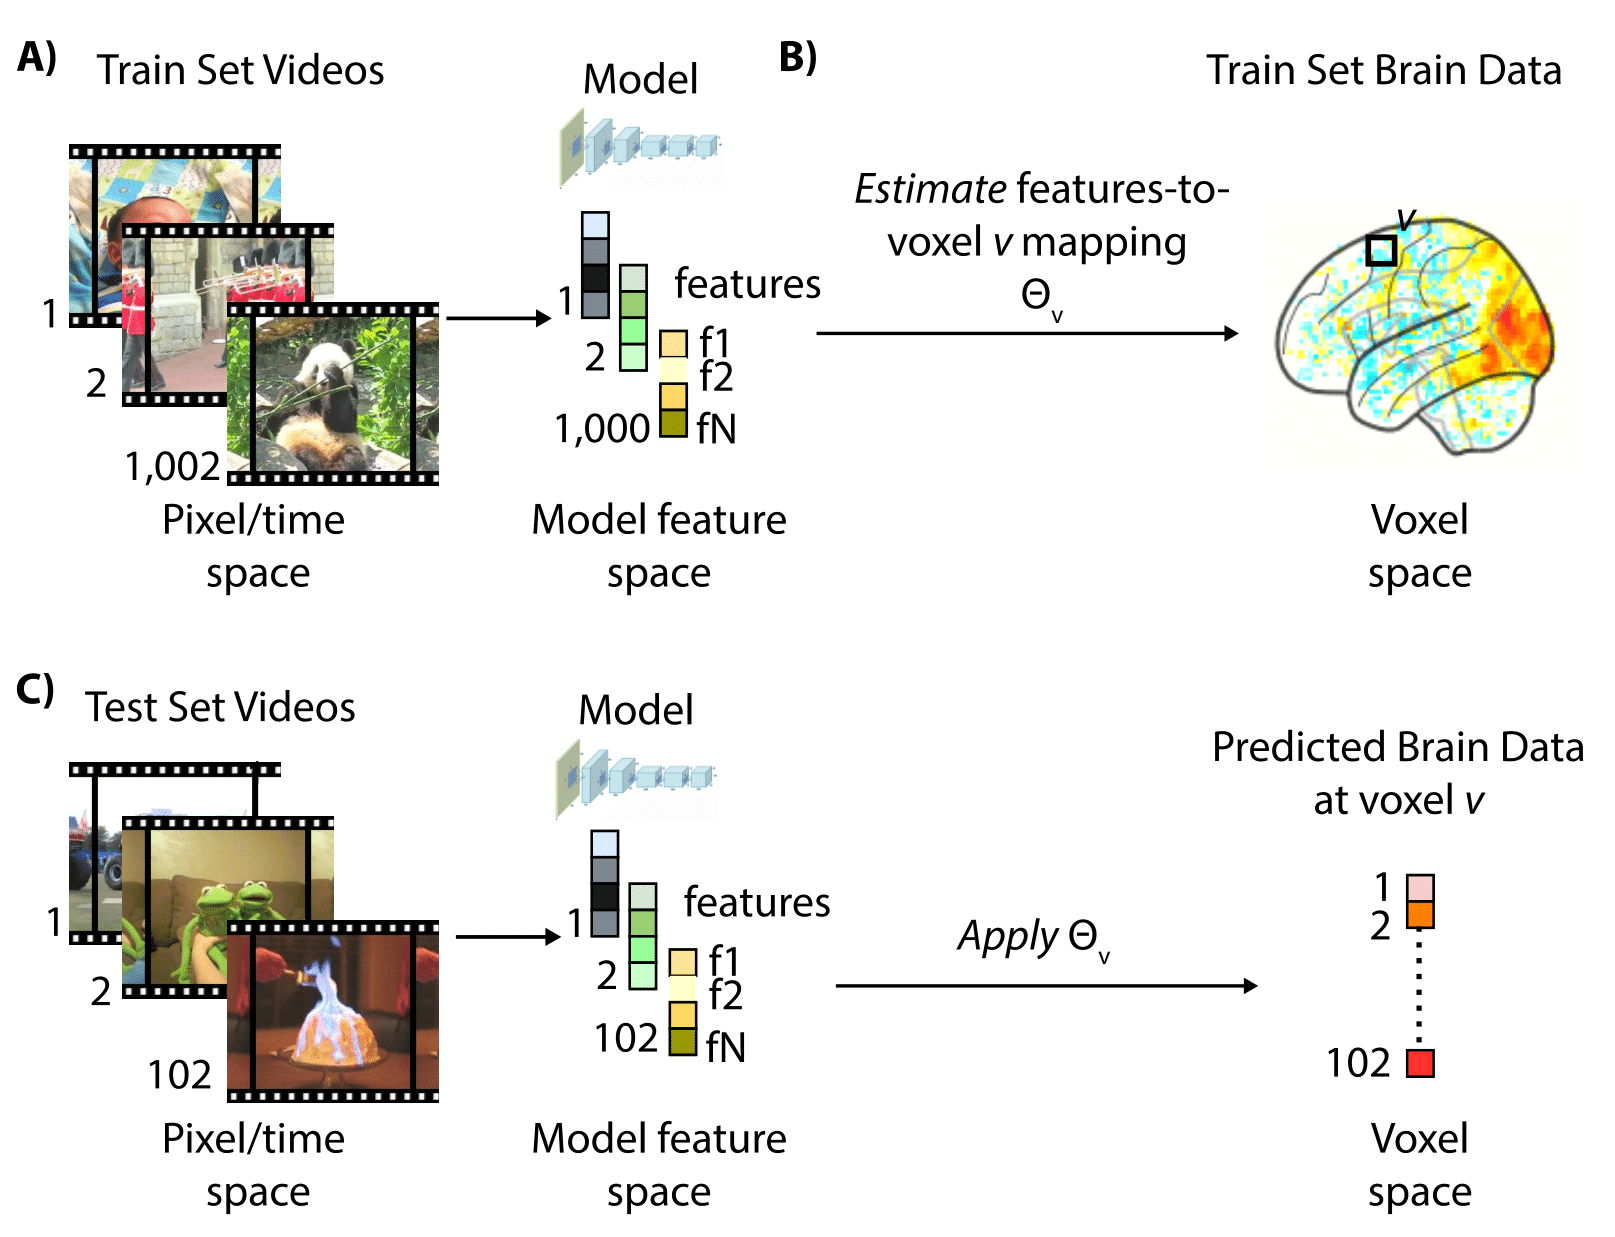

**Figure 1**: **A)** First, given the training set videos, the features of a computational model are extracted. **B)** A mapping between model features and brain voxels is estimated from the Training Set videos. **C)** A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.

## Evaluation

To determine how well a model predicts brain responses we compare synthetic brain data (i.e. those predicted from your model to the left out video clips) to the empirically measured brain responses. The comparison is carried out using Pearson's correlation, comparing for each voxel the 100-dimensional vector formed by the activations for the 100 validation set video clips.

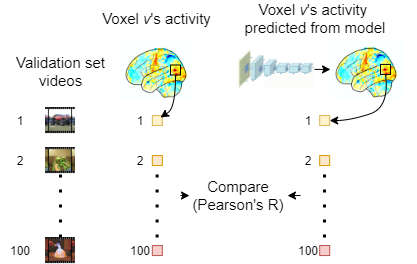

In [ ]:
#@title Utility functions for regression
def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None

    def fit(self,X,y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        X =  self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()
        XtX = torch.matmul(X.t(),X)
        Xty = torch.matmul(X.t(),y.unsqueeze(2))
        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        betas_cholesky, _ = torch.solve(Xty, XtX)

        self.coefficients = betas_cholesky

    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
        entry =  self._concatenate_ones(entry)
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry,self.coefficients)
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.
    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.
    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .
    """

    reg = OLS_pytorch(use_gpu)
    reg.fit(train_activations,train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    return fmri_pred_test

            

In [ ]:
def perform_encoding(activation_dir, fmri_dir,results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
  if torch.cuda.is_available():
      use_gpu = True
  else:
      use_gpu = False

  ###### Load activations ##############
  activations_dir = '/content/activations_alexnet'
  pca_dir = os.path.join(activations_dir,'pca_100')
  train_activations,test_activations = get_activations(pca_dir, layer)
  ######################################

  ##### Load fMRI data #################
  if ROI == "WB":
      track = "full_track"
  else:
      track = "mini_track"
  fmri_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(fmri_dir, sub)
  if track == "full_track":
      fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
  else:
      fmri_train_all = get_fmri(sub_fmri_dir,ROI)
  num_voxels = fmri_train_all.shape[1]
  ######################################


  #### Creating data splits ###############
  if mode == 'val':
      # Here as an example we use first 900 videos as training and rest of the videos as validation
      test_activations = train_activations[900:,:]
      train_activations = train_activations[:900,:]
      fmri_train = fmri_train_all[:900,:]
      fmri_test = fmri_train_all[900:,:]
      pred_fmri = np.zeros_like(fmri_test)
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
  else:
      fmri_train = fmri_train_all
      num_test_videos = 102
      pred_fmri = np.zeros((num_test_videos,num_voxels))
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
  ######################################

  ######## Performing regression ################
  iter = 0
  
  while iter < num_voxels-batch_size:
      pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
      iter = iter+batch_size
  pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
  if mode == 'val':
    score = vectorized_correlation(fmri_test,pred_fmri)
    print("----------------------------------------------------------------------------")
    print("Mean correlation for ROI : ",ROI, "in ",sub," using ",layer, " is :", round(score.mean(), 6))
    ################################################
    
    nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
    ######## Result visualization ################
    if track == "full_track" and visualize_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = '/content/example.nii'
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                          title='Correlation for ' + sub+ ' and ' + layer,
                          display_mode='lyr',colorbar=True,vmin=-1,vmax=1)

    ################################################

  np.save(pred_fmri_save_path, pred_fmri)


In [ ]:
#@title Perform and evaluate encoding on validation set
sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

ROI = 'EBA'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

layer = 'layer_5' #@param ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8"]

fmri_dir = '/content/participants_data_v2021'
prediction_dir = '/content/prediction'
model = 'alexnet'

if ROI == "WB":
    track = "full_track"
else:
    track = "mini_track"

results_dir = os.path.join(prediction_dir,model, layer,\
                           track, sub)
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
perform_encoding(activations_dir, fmri_dir,\
                                 results_dir, sub, layer, ROI=ROI)
  

If you use the default parameters (sub04, EBA, layer_5) you should obtain a correlation of 0.219 between predicted and recorded fMRI responses on validation videos.

# Predict fMRI responses to test videos for all subjects all ROIs
Run the cell below to save predicted fMRI responses to test videos for all subjects and ROIs.

In [ ]:
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layer = 'layer_5'
model = 'alexnet'
for sub in subs:
  for ROI in ROIs:
    if ROI == "WB":
        track = "full_track"
    else:
        track = "mini_track"
    results_dir = os.path.join(prediction_dir,model, layer,\
                           track, sub)
    if not os.path.exists(results_dir):
      os.makedirs(results_dir)
    print ("Starting ROI: ", ROI, "sub: ",sub)
    perform_encoding(activations_dir, fmri_dir,\
                     results_dir, sub, layer,\
                     ROI=ROI,mode='test')
    print ("Completed ROI: ", ROI, "sub: ",sub)
    print("----------------------------------------------------------------------------")

# Prepare submission files

Now, we will prepare the zipfiles for submission to codalab. After running the two cells below you will see a Pickle and a zip file (containing the Pickle file) for the corresponding track in the colab file directory. 

Submit the mini_track results [here](https://competitions.codalab.org/competitions/30930#participate-submit_results) and full_track results [here](https://competitions.codalab.org/competitions/30937#participate-submit_results)

In [ ]:
def prepare_results(submission_dir, track):
    if track == 'full_track':
        ROIs = ['WB']
    else:
        ROIs = ['LOC','FFA','STS','EBA','PPA','V1','V2','V3','V4']

    num_subs = 10
    subs=[]
    for s in range(num_subs):
        subs.append('sub'+str(s+1).zfill(2))

    results = {}
    for ROI in ROIs:
        ROI_results = {}
        for sub in subs:
            ROI_result_file = os.path.join(submission_dir,track,sub,ROI+"_test.npy")
            if not os.path.exists(ROI_result_file):
                print("---------Warning : submission not ready ----------")
                print("Result not found for ",sub, " and ROI: ",ROI)
                print("Result file path: ", ROI_result_file)
                print("Please check if the directory is correct or generate predicted data for ROI: ",ROI , " in subject: ", sub)
                return
            ROI_result = np.load(ROI_result_file)
            ROI_results[sub] = ROI_result
        results[ROI] = ROI_results

    save_dict(results,track+".pkl")
    zipped_results = zipfile.ZipFile(track+".zip", 'w')
    zipped_results.write(track+".pkl")
    zipped_results.close()

In [ ]:
import zipfile
submission_dir = '/content/prediction/alexnet/layer_5'
prepare_results(submission_dir, 'full_track')
prepare_results(submission_dir, 'mini_track')

Click the folder button on the left panel and you should see zipfiles ready for submission

# Reference

[The Algonauts Project 2021 Challenge: How the Human Brain Makes Sense of a World in Motion. 
*Cichy et al. arxiv 2021*](https://arxiv.org/abs/2104.13714v1)